## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geocomp' #dataset-compression
TRANSFORM = 'fft-normal_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
normal_intensity_fft_1e5geocomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/jiaxin/Documents/Summer 2025/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5geocomp/fft/normal_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


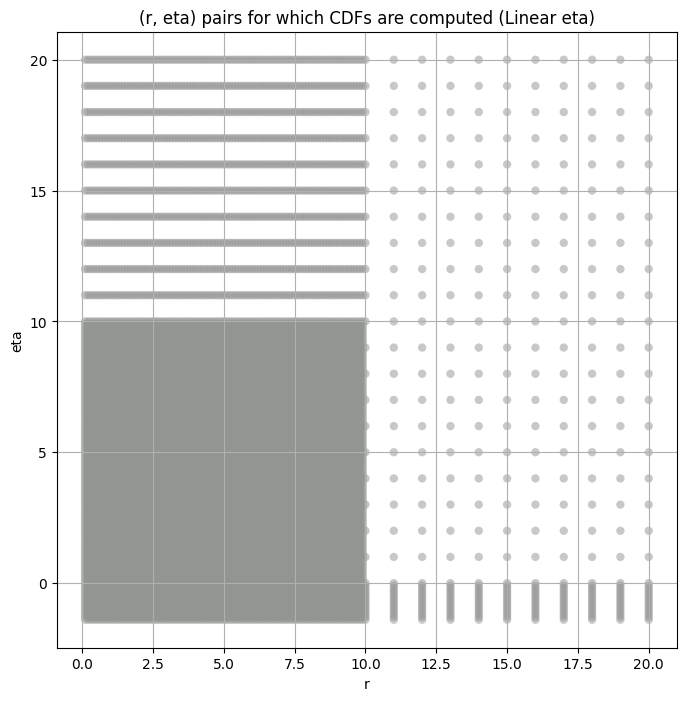

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     2.687462e+14  2.444812e+14  2.967340e+14    6.709019    2.892513   
5     5.361263e+14  4.498260e+14  6.320004e+14   41.450941   33.774703   
8     8.102473e+13  6.454183e+13  1.024136e+14   79.652079   32.607359   
11    1.102342e+13  8.473030e+12  1.559962e+13  159.646159   14.550794   
14    2.499556e+14  2.258030e+14  2.760694e+14   13.192875   10.236113   
17    3.874547e+14  3.631300e+14  4.138468e+14    4.386029    2.848984   
20    8.277627e+13  7.680817e+13  8.937703e+13    6.703176    4.336493   
23    7.691854e+12  7.271829e+12  8.154133e+12    2.935631    1.709797   
26    3.254715e+12  3.037563e+12  3.506743e+12    5.652777    3.258412   
30    4.508071e+10  4.157892e+10  4.895770e+10    7.918080    5.261427   

      kurt_upper  total_samples  
band                             
2      10.921011         3072.0  
5      49.184785         9216.0  
8     121.646730        26112.0  
11    415.473312        72192.0  
14     17.540052       100000.0  
17      8.834303       100000.0  
20     12.764984       100000.0  
23      6.843272       100000.0  
26     15.071962       100000.0  
30     16.343210       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     2.687462e+14   2.687462e+14    2.181612e+14    2.007707e+14   
5     5.361263e+14   5.361263e+14    3.874153e+14    3.101490e+14   
8     8.102473e+13   8.102473e+13    6.204309e+13    5.515005e+13   
11    1.102342e+13   1.102342e+13    8.610438e+12    8.037296e+12   
14    2.499556e+14   2.499556e+14    2.398283e+14    2.332955e+14   
17    3.874547e+14   3.874547e+14    3.775394e+14    3.715998e+14   
20    8.277627e+13   8.277627e+13    8.009182e+13    7.852253e+13   
23    7.691854e+12   7.691854e+12    7.521187e+12    7.422545e+12   
26    3.254715e+12   3.254715e+12    3.158794e+12    3.105252e+12   
30    4.508071e+10   4.508071e+10    4.357054e+10    4.268058e+10   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       1.875860e+14     1.770385e+14     1.609280e+14     1.470796e+14   
5       2.657301e+14     2.350712e+14     1.972179e+14     1.735292e+14   
8       5.205127e+13     4.989651e+13     4.679656e+13     4.461254e+13   
11      7.781290e+12     7.605355e+12     7.362542e+12     7.180059e+12   
14      2.278514e+14     2.230412e+14     2.147262e+14     2.075521e+14   
17      3.667460e+14     3.625248e+14     3.552071e+14     3.488764e+14   
20      7.723469e+13     7.610881e+13     7.417969e+13     7.251926e+13   
23      7.340975e+12     7.269459e+12     7.145331e+12     7.037571e+12   
26      3.061200e+12     3.022639e+12     2.955769e+12     2.898024e+12   
30      4.194282e+10     4.129354e+10     4.016791e+10     3.919593e+10   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        1.355440e+14     1.253469e+14     1.164204e+14     9.503203e+13  
5        1.571364e+14     1.454761e+14     1.366385e+14     1.179070e+14  
8        4.294132e+13     4.155627e+13     4.037800e+13     3.760662e+13  
11       7.032045e+12     6.907691e+12     6.802524e+12     6.550495e+12  
14       2.011502e+14     1.953533e+14     1.899887e+14     1.759745e+14  
17       3.431553e+14     3.379434e+14     3.331117e+14     3.202130e+14  
20       7.104383e+13     6.971002e+13     6.848174e+13     6.527151e+13  
23       6.940896e+12     6.852381e+12     6.770271e+12     6.551586e+12  
26       2.846632e+12     2.799886e+12     2.756776e+12     2.643549e+12  
30       3.832971e+10     3.754246e+10     3.681800e+10     3.491771e+10

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.006308037669235378 268746194173039.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.008447919963545991 218161234615652.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.013494138567864855 200770742416356.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.018265554079830326 187585984009620.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.023940683564633747 177038515712683.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.03476841024528321 160927955765978.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.044980326974821266 147079639165533.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.05416179449941552 135543973918935.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.06284433146302904 125346876567701.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.07092120941894398 116420411998280.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.09247543478808706 95032034512677.75
Number of samples: 6144, Without approximation : 3072.0


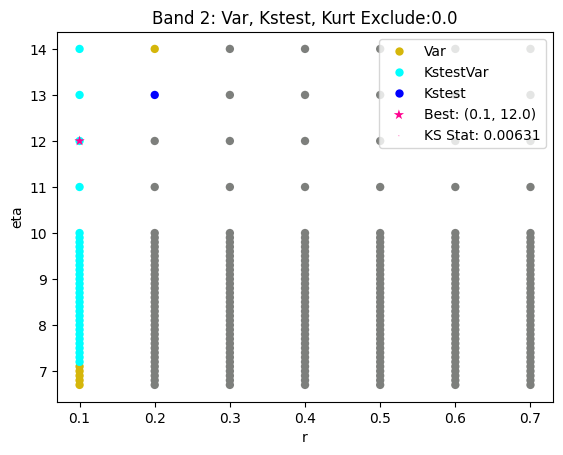

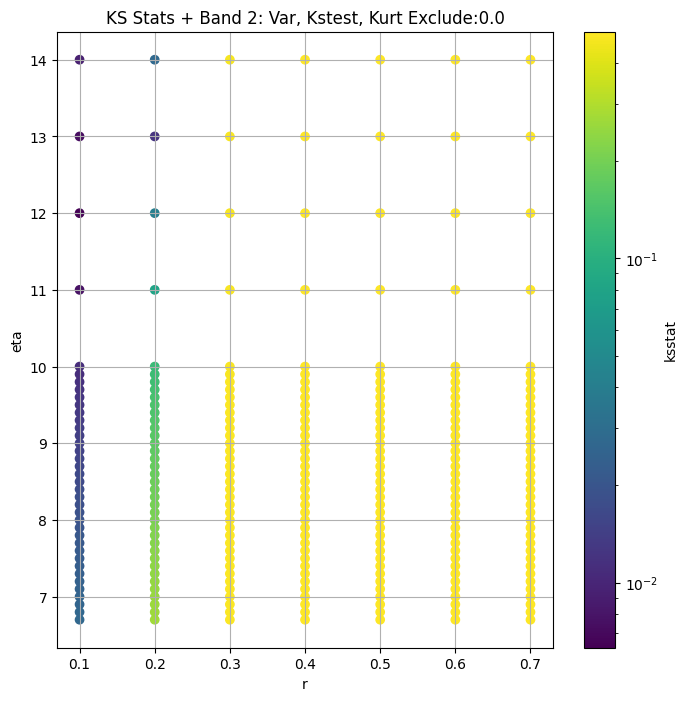

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.01644781713832333 536126300279723.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.01644781713832333 387415293417592.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.01644781713832333 310148998943531.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.013353643220963107 265730098742500.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.009560585140172106 235071160193927.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.010220669737702314 197217931964264.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.012364263237848117 173529150402589.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.01508673872634237 157136421258057.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.01941766948892598 145476096940153.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.02178796368686884 136638453367308.73


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.02948855926152949 117907042246995.38
Number of samples: 18432, Without approximation : 9216.0


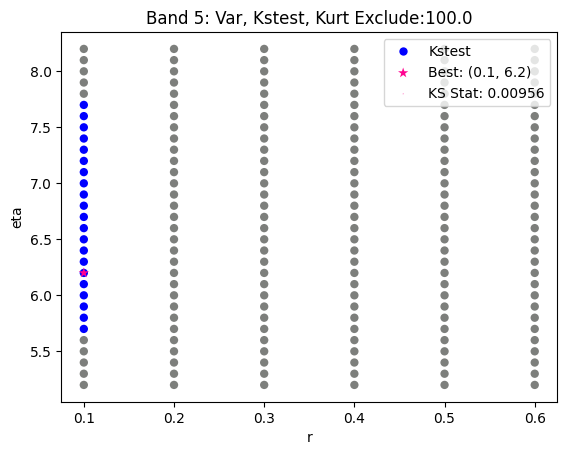

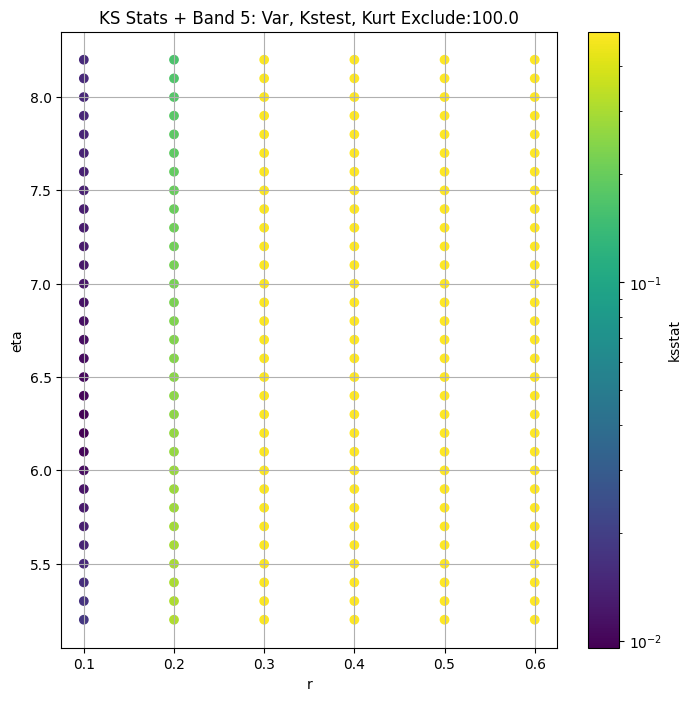

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.005502839314398877 81024726553361.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.005502839314398877 62043088977788.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.005502839314398877 55150053059616.04


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.005502839314398877 52051274450163.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005502839314398877 49896505932226.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.005502839314398877 46796561091282.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.005762473414662073 44612540722518.305


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0063468474168518335 42941317501356.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.007068972681152196 41556265377012.086


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007848549603248656 40377996889857.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010853328608299614 37606621533864.15
Number of samples: 52224, Without approximation : 26112.0


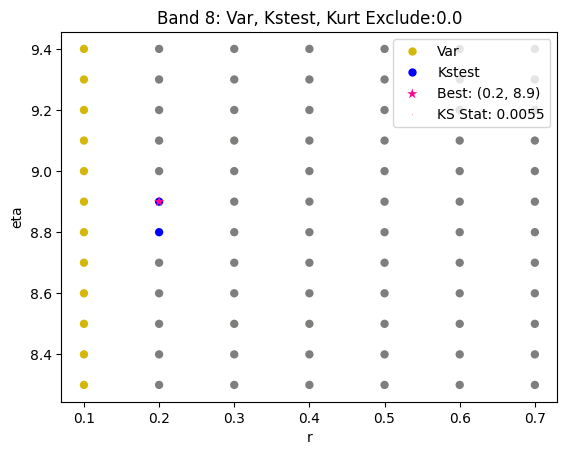

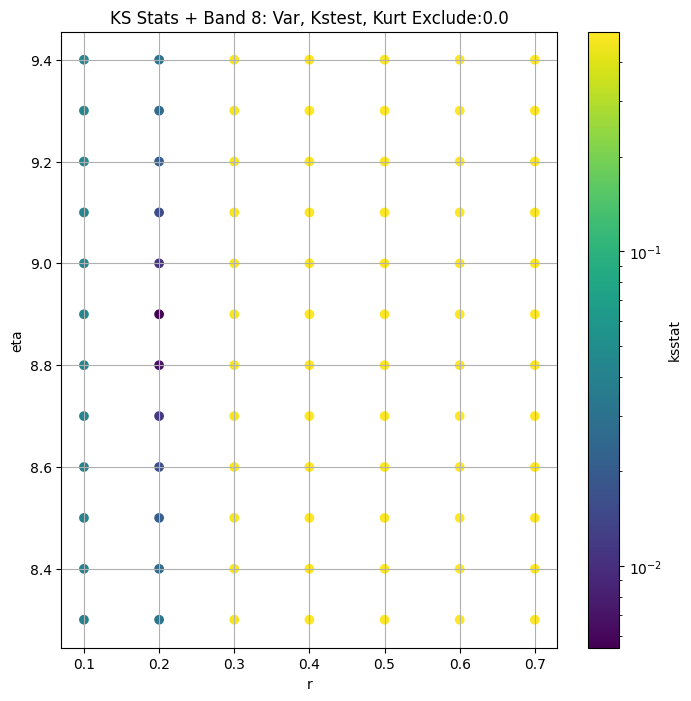

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.010292333185347669 11023422013304.93


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.010292333185347669 8610438232919.32


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0075130739060098595 8037295782069.327


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.005889914222123482 7781289643498.509


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.004941492303564665 7605355371948.161


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0032752959599183784 7362541668978.769


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.0030353180749971434 7180058586242.688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.0032279875530951633 7032045310881.556


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.003527979451183251 6907691229639.546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.0039762679684152025 6802523731914.792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.00821782189166137 6550495114102.386
Number of samples: 100000, Without approximation : 72192.0


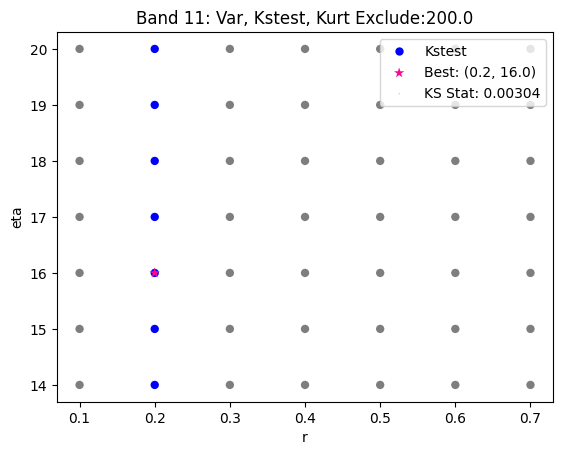

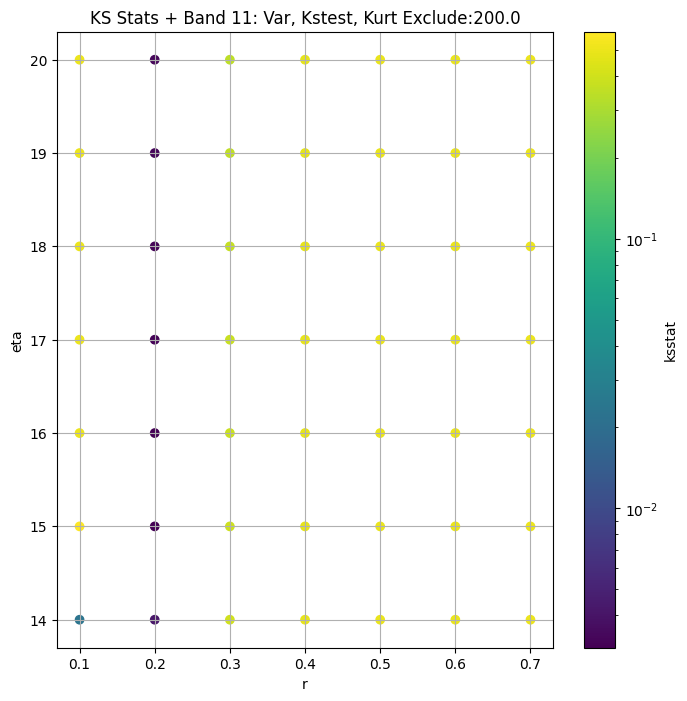

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.028898861347149474 249955571353169.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.028278624637637778 239828345890843.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.02930120976530145 233295498483063.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.030167123719704356 227851387679062.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.030982483532827676 223041187826506.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.029866766216874167 214726172504992.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.031127140594367136 207552132054999.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.032277345788879204 201150206520681.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.031343315202915445 195353286986826.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.03220188594260626 189988730380728.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.033096336962669975 175974510563687.4
Number of samples: 100000, Without approximation : 100000.0


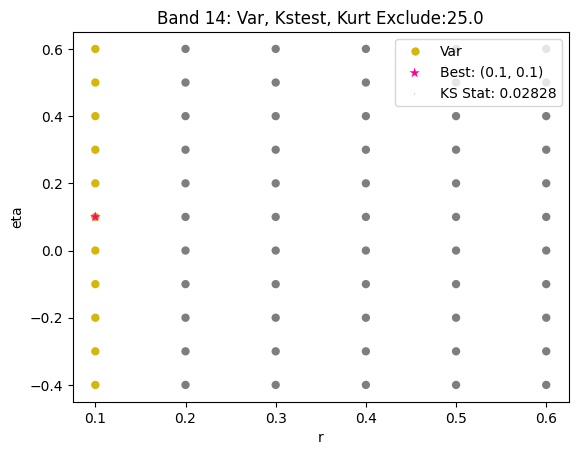

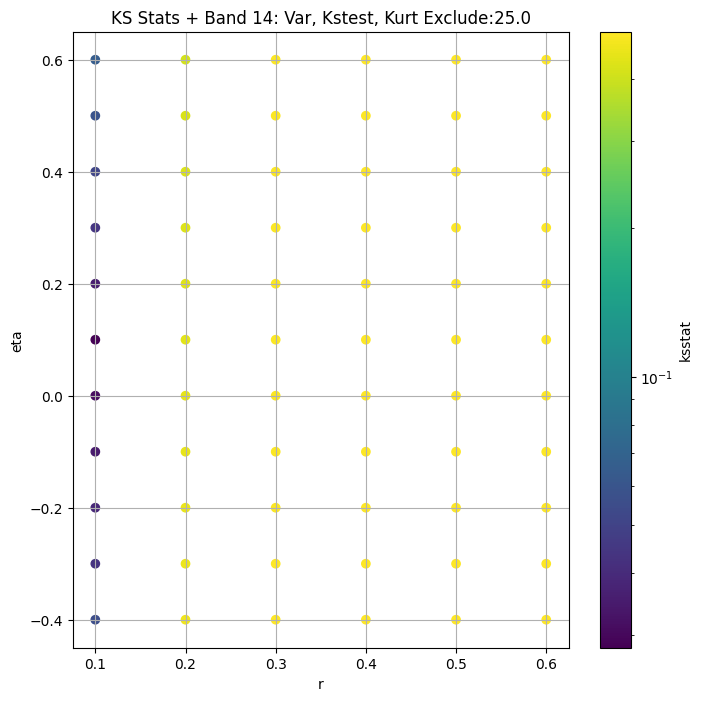

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.005054560874242636 387454656843114.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.00578405172974461 377539350573560.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.006216936557340791 371599817671463.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.006652446196554307 366745956663475.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.006949814074315455 362524758337688.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.007617677410211382 355207063238829.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.008330741186874602 348876372734833.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.008968947153192908 343155320494504.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.009876356837680816 337943366426001.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.010367773176313655 333111679452228.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.011988095355797049 320212965459411.94
Number of samples: 100000, Without approximation : 100000.0


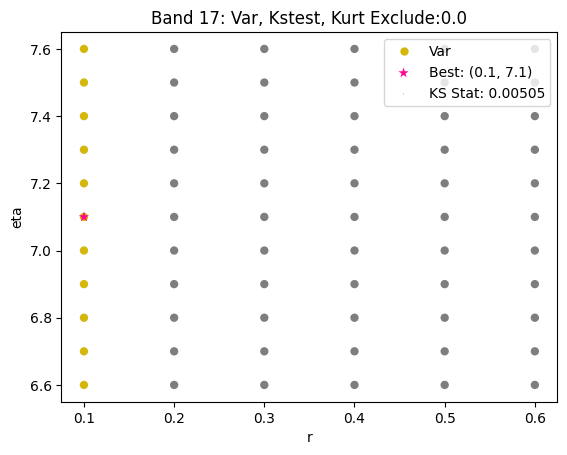

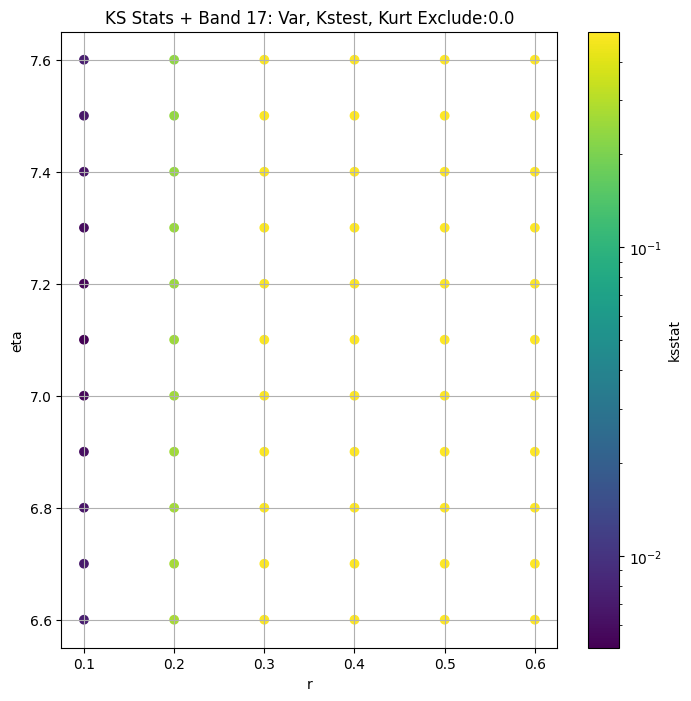

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.0032378583652232784 82776272831579.88


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0023473113686637292 80091816034587.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0018891136853122457 78522529555781.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.002330390565183412 77234687870456.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.0028109186470403474 76108809433445.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.0037430134511498986 74179693121512.92


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.0045999878925876495 72519259159069.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.005394766484017332 71043828071960.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.006154300580601388 69710015720494.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.006892555923272165 68481742147767.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.009009327749872661 65271511630180.375
Number of samples: 100000, Without approximation : 100000.0


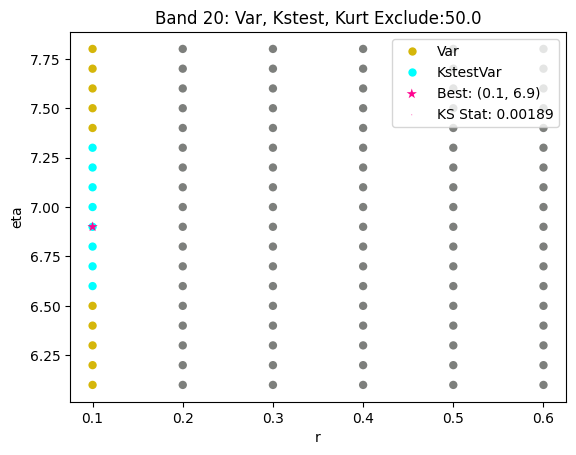

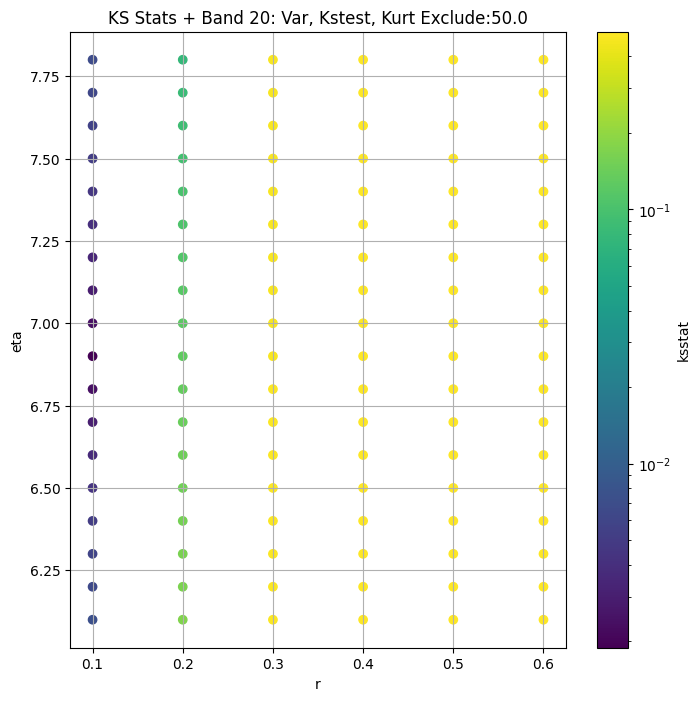

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0014338883257629664 7691854197036.044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0005364161503852646 7521186945522.781


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0009187035408134148 7422544904288.13


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.001397446086889527 7340975441866.975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0019418791647282455 7269458903185.694


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0029133521053660294 7145330930313.338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0037867110034301085 7037571255523.624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004603073274653861 6940896349796.533


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005373293652037092 6852381425224.401


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.006100895127053113 6770271439311.563


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.0081352086952697 6551585783258.96
Number of samples: 100000, Without approximation : 100000.0


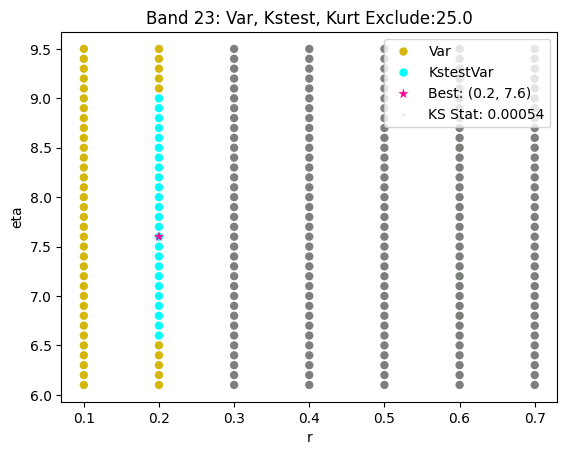

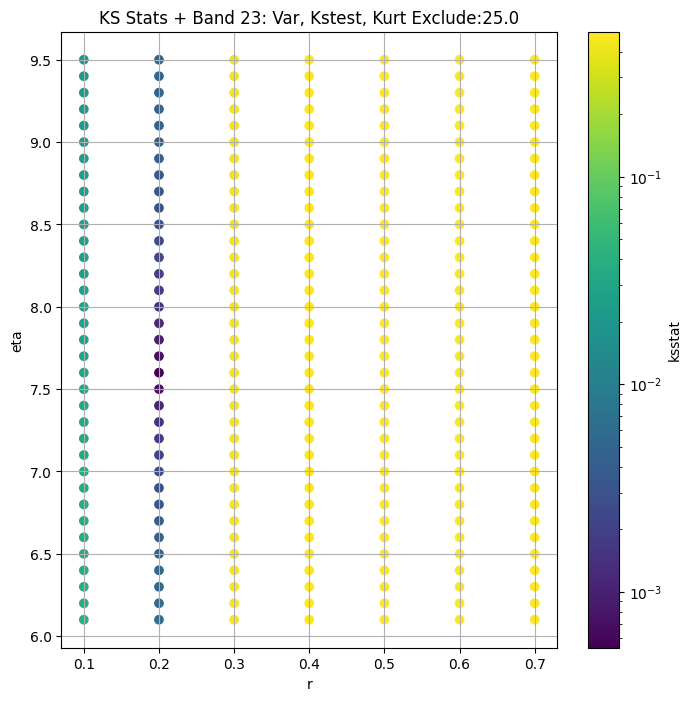

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0006343875701389778 3254714997040.671


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0017174281689310705 3158793998806.417


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0024076303323364717 3105251914001.2065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.00303142136335946 3061199657828.3804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.0035252771793960955 3022638544015.186


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.004506968537491121 2955769256144.8013


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.005250838160161142 2898024140915.0625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005794229341060143 2846631805988.711


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006570436443095573 2799886263051.7964


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.007335728919826 2756776228344.726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.009451906636866604 2643549229537.1978
Number of samples: 100000, Without approximation : 100000.0


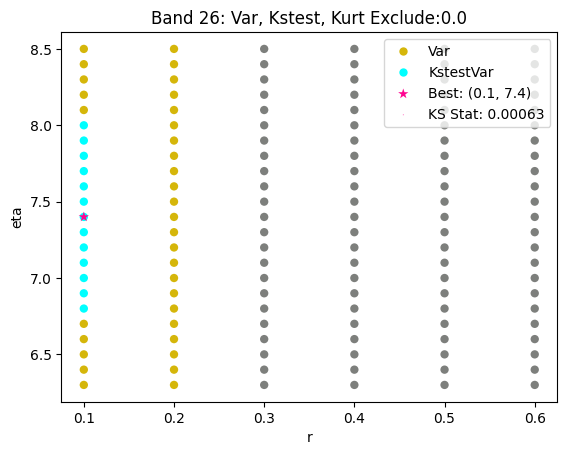

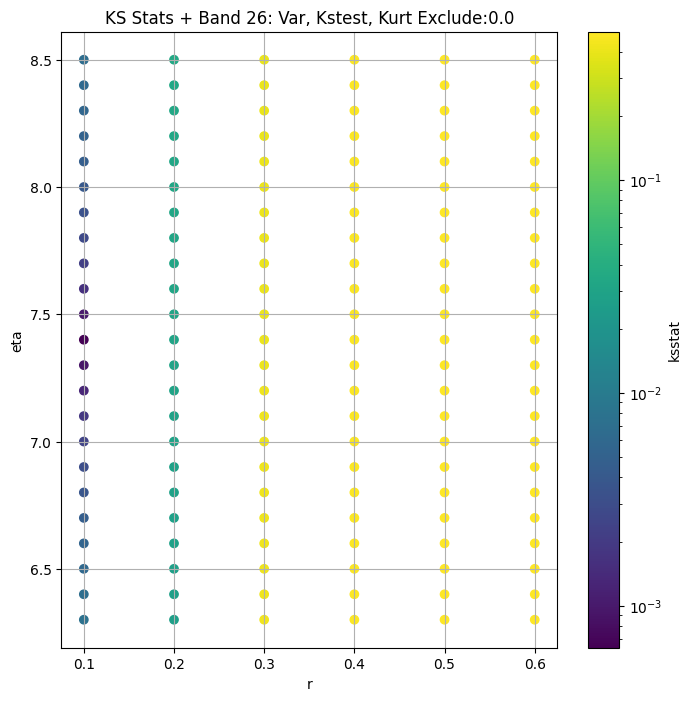

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.0024258768406397735 45080710644.99423


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.002665947968707484 43570540517.67537


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.0033236852422192723 42680576420.615654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.004077555759774518 41942822849.6145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.004533951357955902 41293535784.90712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.005561624725890391 40167906343.218056


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.006306919603706884 39195926323.139656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.007172576083333271 38329710466.95734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.007980828789301397 37542461921.22295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.008613954115099881 36818001034.75522


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.010679396194839264 34917712809.20839
Number of samples: 100000, Without approximation : 100000.0


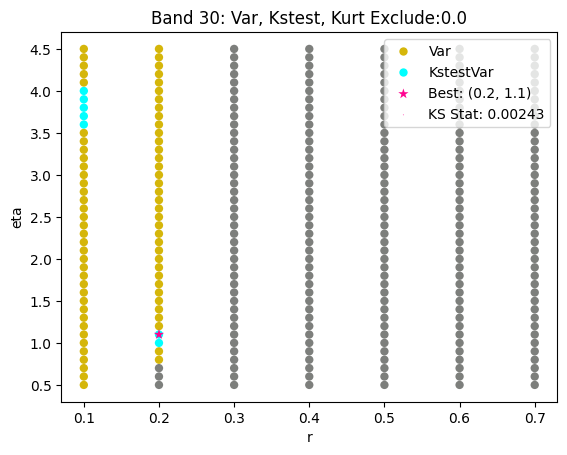

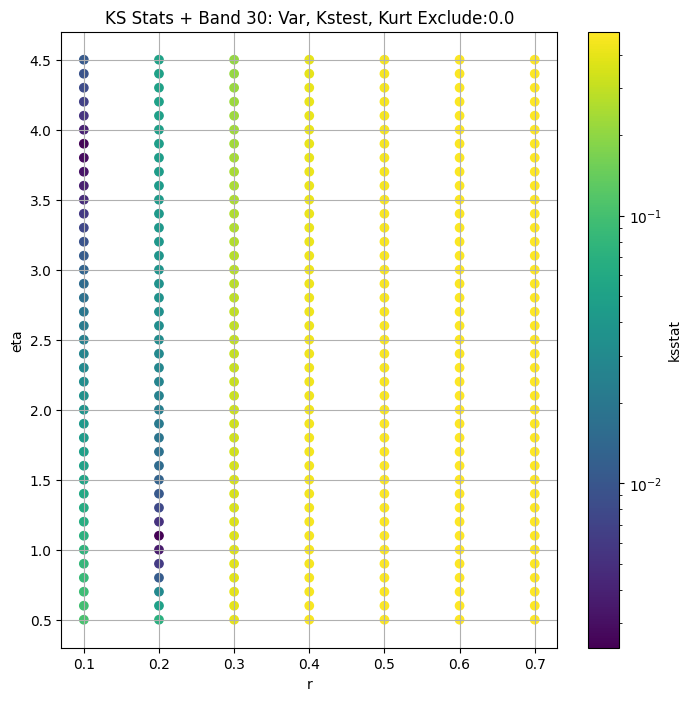

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     2.687462e+14  2.444812e+14  2.967340e+14    6.709019    2.892513   
5     5.361263e+14  4.498260e+14  6.320004e+14   41.450941   33.774703   
8     8.102473e+13  6.454183e+13  1.024136e+14   79.652079   32.607359   
11    1.102342e+13  8.473030e+12  1.559962e+13  159.646159   14.550794   
14    2.499556e+14  2.258030e+14  2.760694e+14   13.192875   10.236113   
17    3.874547e+14  3.631300e+14  4.138468e+14    4.386029    2.848984   
20    8.277627e+13  7.680817e+13  8.937703e+13    6.703176    4.336493   
23    7.691854e+12  7.271829e+12  8.154133e+12    2.935631    1.709797   
26    3.254715e+12  3.037563e+12  3.506743e+12    5.652777    3.258412   
30    4.508071e+10  4.157892e+10  4.895770e+10    7.918080    5.261427   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      10.921011         3072.0             0.006308        0.1         12.0   
5      49.184785         9216.0             0.009561        0.1          6.2   
8     121.646730        26112.0             0.005503        0.2          8.9   
11    415.473312        72192.0             0.003035        0.2         16.0   
14     17.540052       100000.0             0.028279        0.1          0.1   
17      8.834303       100000.0             0.005055        0.1          7.1   
20     12.764984       100000.0             0.001889        0.1          6.9   
23      6.843272       100000.0             0.000536        0.2          7.6   
26     15.071962       100000.0             0.000634        0.1          7.4   
30     16.343210       100000.0             0.002426        0.2          1.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      9.649863e-08                     0.0        2.687462e+14   
5      1.829462e-05                   100.0        2.350712e+14   
8      1.000000e+05                     0.0        8.102473e+13   
11     1.251077e+03                   200.0        7.180059e+12   
14     2.021876e+01                    25.0        2.398283e+14   
17     1.056633e-05                     0.0        3.874547e+14   
20     2.678249e-06                    50.0        7.852253e+13   
23     3.117321e+04                    25.0        7.521187e+12   
26     6.403948e-08                     0.0        3.254715e+12   
30     6.070986e+04                     0.0        4.508071e+10   

      kstest_stat_cutoff_0.05  
band                           
2                    0.024448  
5                    0.014129  
8                    0.008398  
11                   0.005052  
14                   0.004293  
17                   0.004293  
20                   0.004293  
23                   0.004293  
26                   0.004293  
30                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.03185700933881097, var: 177038515712683.4


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.02548922221441019, var: 187585984009620.0


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.017991627116810016, var: 200770742416356.9


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.008808871063578638, var: 218161234615652.9


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.006308037669235378, var: 268746194173039.66
Number of samples: 6144, Without approximation : 3072.0


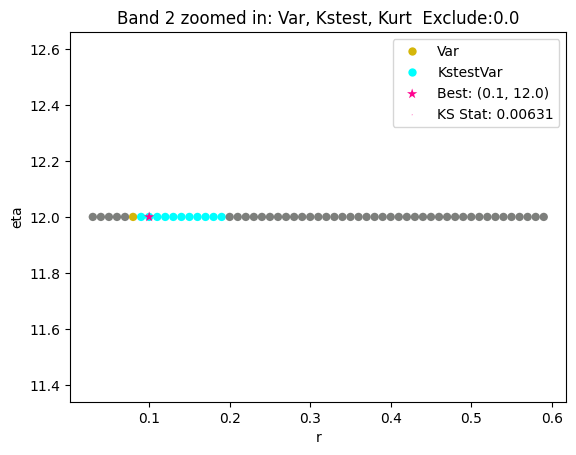

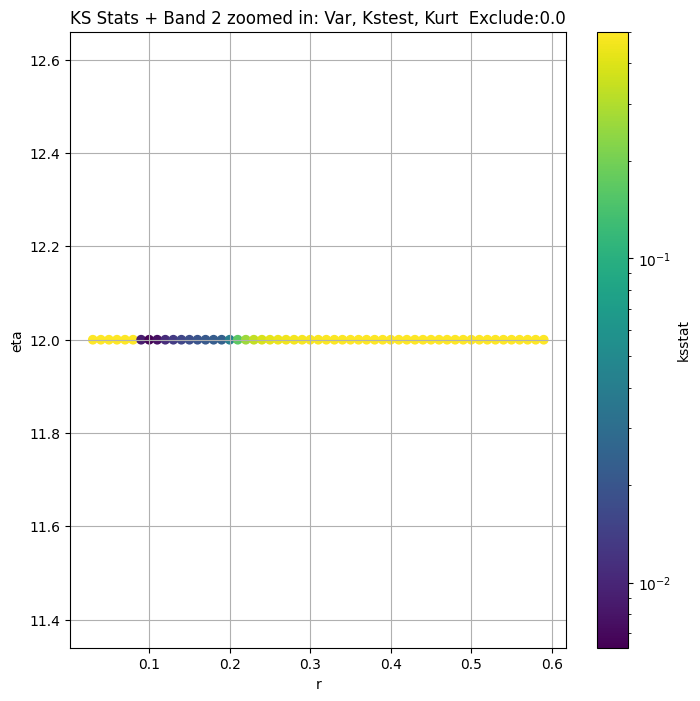

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.012223232937140005, var: 173529150402589.28


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.011121854125955458, var: 184248982627631.62


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.010221282874560589, var: 197217931964264.28


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.00927346307211907, var: 213142162766078.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.009560585140172106, var: 235071160193927.28


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.01187686382603248, var: 265730098742500.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.01187686382603248, var: 310148998943531.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.01187686382603248, var: 387415293417592.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.01187686382603248, var: 536126300279723.7
Number of samples: 18432, Without approximation : 9216.0


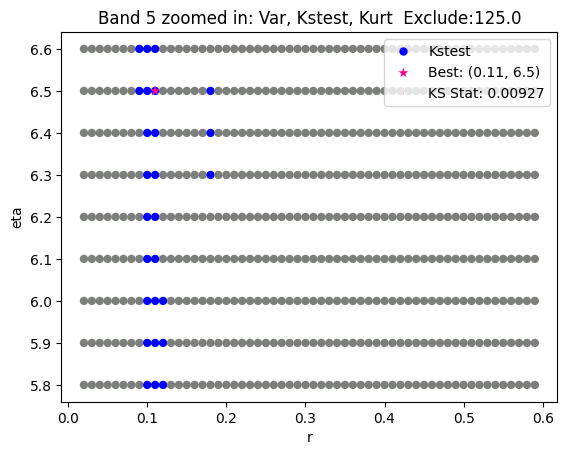

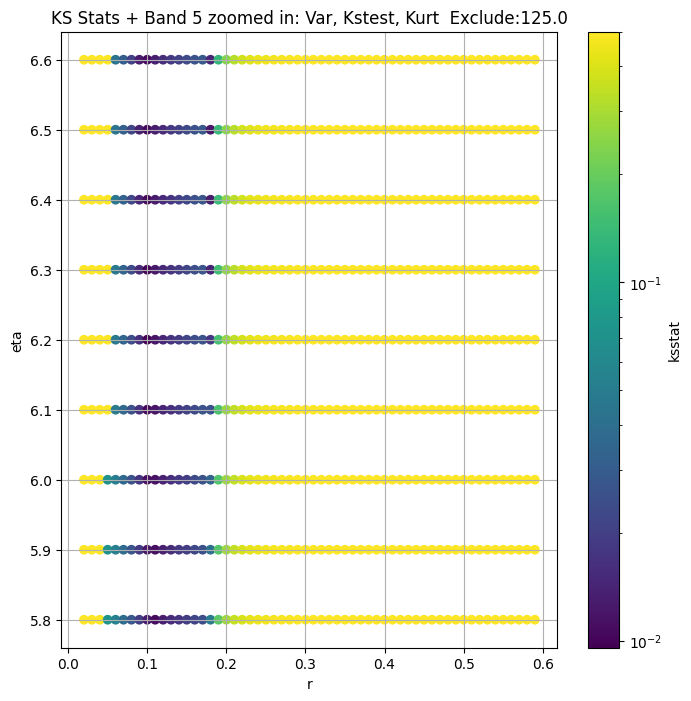

Band 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.005502839314398877, var: 49896505932226.97


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.005502839314398877, var: 52051274450163.19


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.005502839314398877, var: 55150053059616.04


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.005502839314398877, var: 62043088977788.72


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.005502839314398877, var: 81024726553361.3
Number of samples: 52224, Without approximation : 26112.0


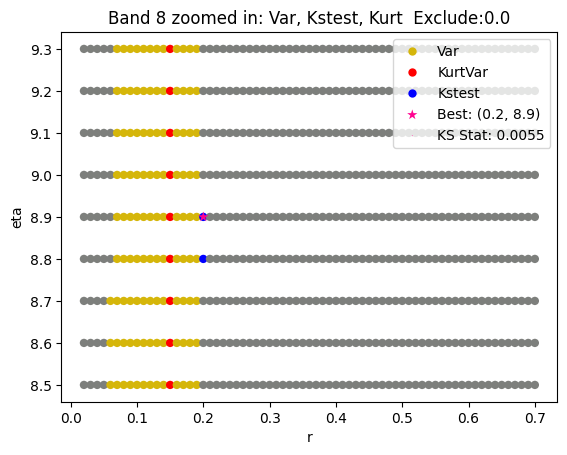

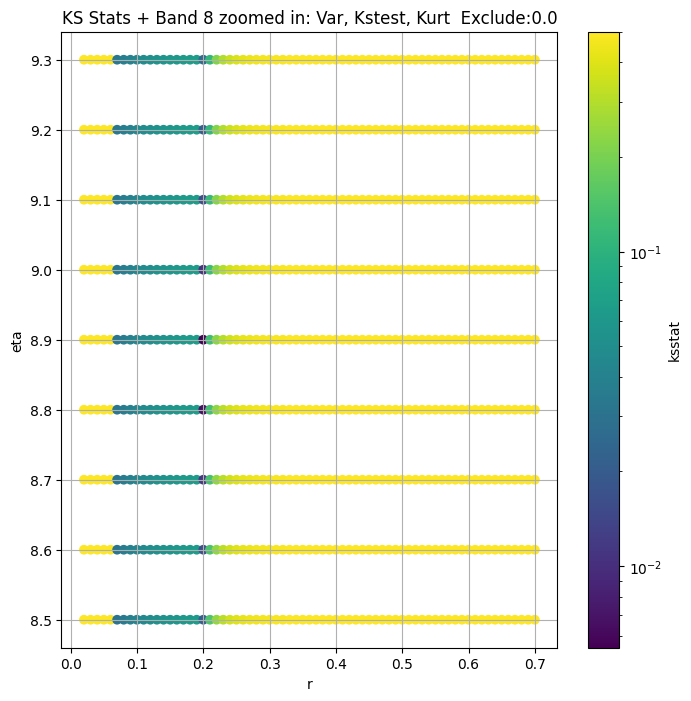

Band 11


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 200.0 + 100 = 300, ksstat: 0.003487176063183179, var: 6907691229639.546


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 200.0 + 75 = 275, ksstat: 0.0033461128016280244, var: 6967392632193.639


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 200.0 + 50 = 250, ksstat: 0.003222117474766716, var: 7032045310881.556


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 200.0 + 25 = 225, ksstat: 0.0030989710772109207, var: 7102456097115.632


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 200.0 + 0 = 200, ksstat: 0.0029592332896088355, var: 7180058586242.688


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 200.0 + -25 = 175, ksstat: 0.0028620161962479296, var: 7266264133542.451


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 200.0 + -50 = 150, ksstat: 0.0030956865114425414, var: 7362541668978.769


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 200.0 + -75 = 125, ksstat: 0.004009936615059773, var: 7471841513295.485


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 200.0 + -100 = 100, ksstat: 0.004681418933782933, var: 7605355371948.161
Number of samples: 100000, Without approximation : 72192.0


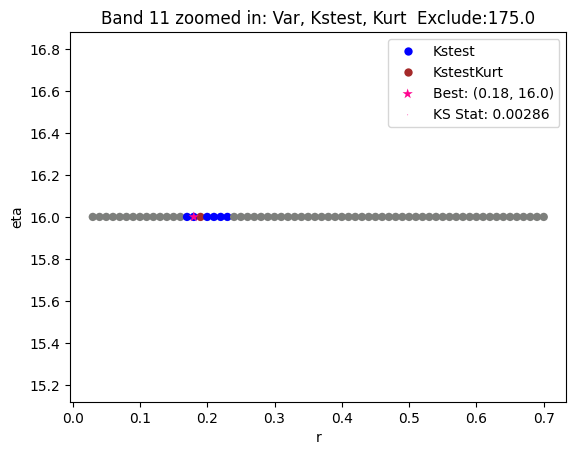

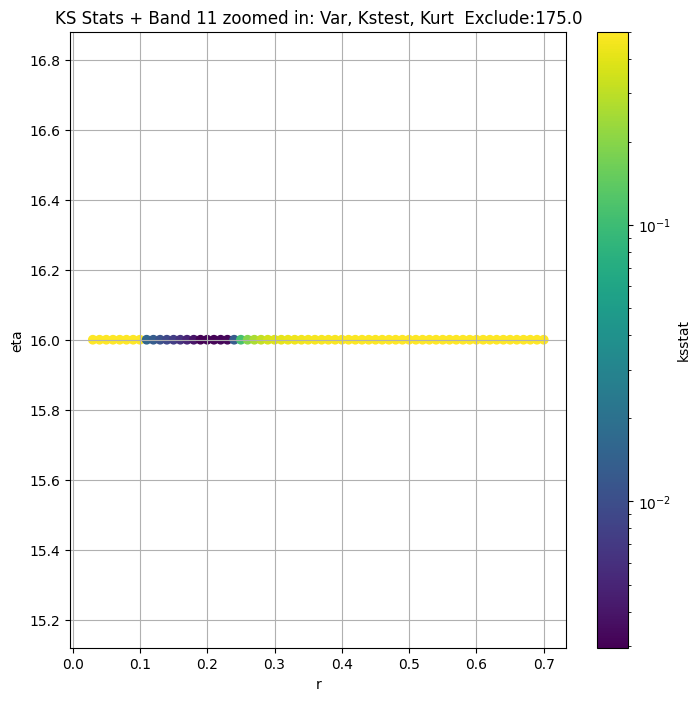

Band 14


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 100 = 125, ksstat: 0.029335133153698192, var: 218709973315067.75


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 75 = 100, ksstat: 0.02860411461230735, var: 223041187826506.75


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 50 = 75, ksstat: 0.029020077078172828, var: 227851387679062.56


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 25 = 50, ksstat: 0.028144993174525165, var: 233295498483063.3


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 0 = 25, ksstat: 0.027117998854088818, var: 239828345890843.1


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + -25 = 0, ksstat: 0.02723265174229593, var: 249955571353169.2
Number of samples: 100000, Without approximation : 100000.0


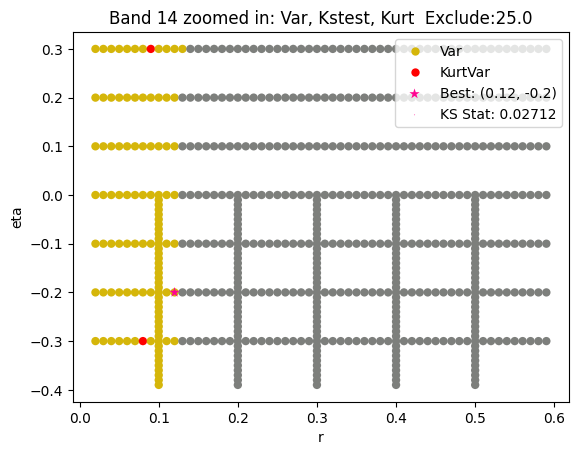

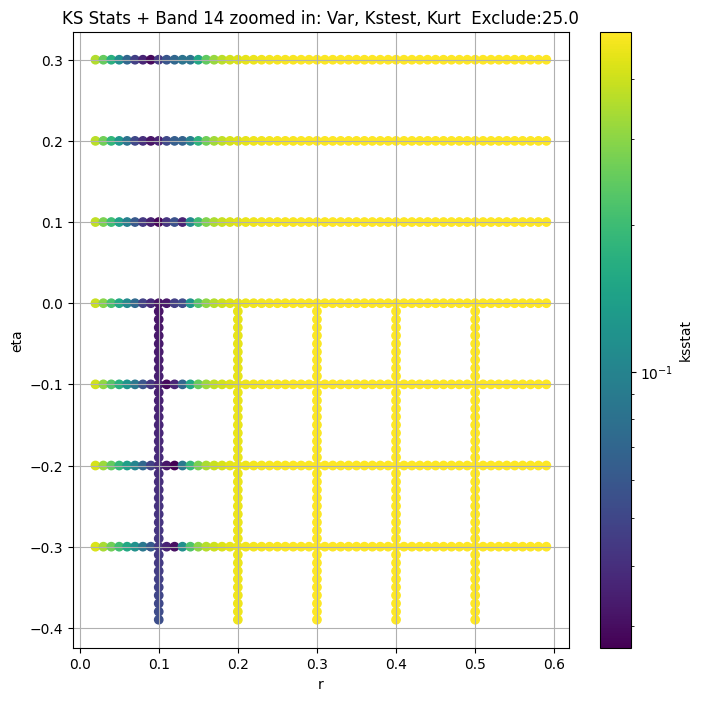

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.006804971629663301, var: 362524758337688.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.006576553153308351, var: 366745956663475.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.006049258843805028, var: 371599817671463.4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.005585311648771088, var: 377539350573560.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.005054560874242636, var: 387454656843114.8
Number of samples: 100000, Without approximation : 100000.0


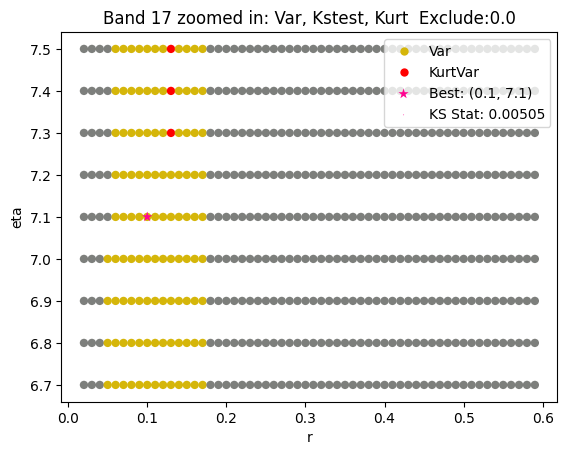

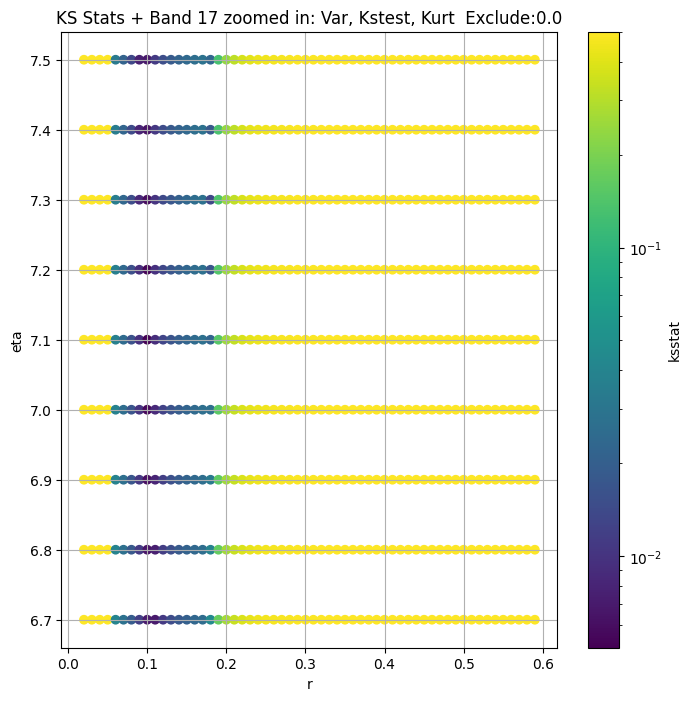

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 100 = 150, ksstat: 0.0037072755793674528, var: 74179693121512.92


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 75 = 125, ksstat: 0.003252266776371169, var: 75101789918871.61


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 50 = 100, ksstat: 0.0027938092227822973, var: 76108809433445.47


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 25 = 75, ksstat: 0.002330390565183412, var: 77234687870456.22


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 0 = 50, ksstat: 0.0018891136853122457, var: 78522529555781.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + -25 = 25, ksstat: 0.0023473113686637292, var: 80091816034587.23


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + -50 = 0, ksstat: 0.0031882388443573717, var: 82776272831579.88
Number of samples: 100000, Without approximation : 100000.0


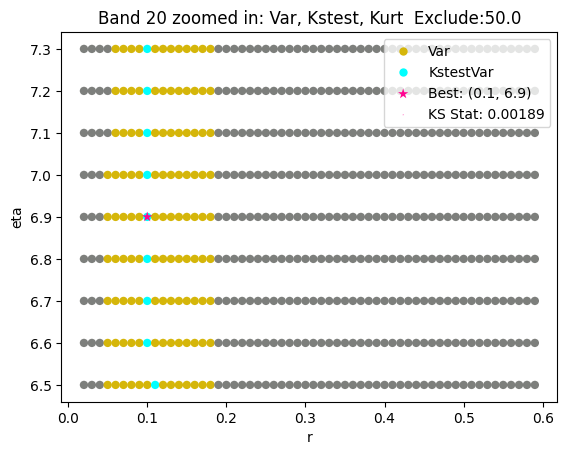

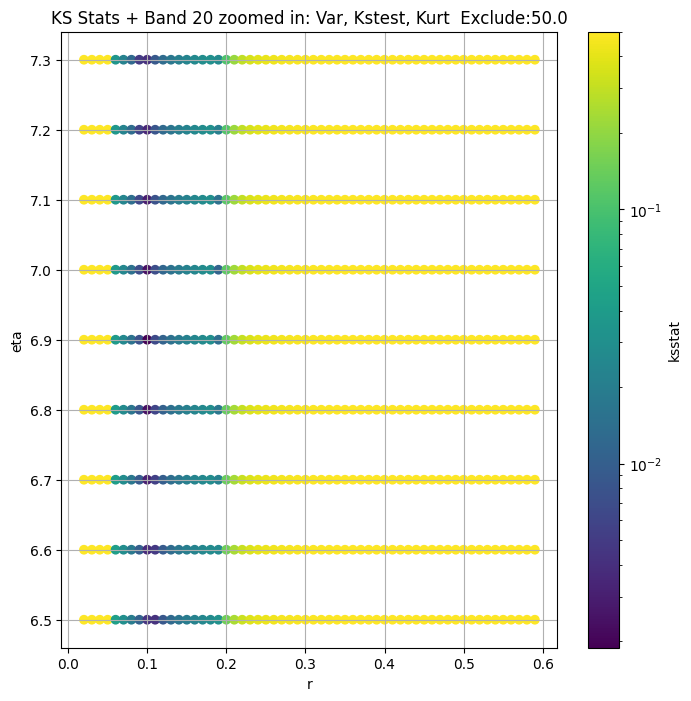

Band 23


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.0024552711061140986, var: 7204835803215.77


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.0019245840755675939, var: 7269458903185.694


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0013793676789784562, var: 7340975441866.975


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.0009187035408134148, var: 7422544904288.13


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0005364161503852646, var: 7521186945522.781


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.0014071196483805837, var: 7691854197036.044
Number of samples: 100000, Without approximation : 100000.0


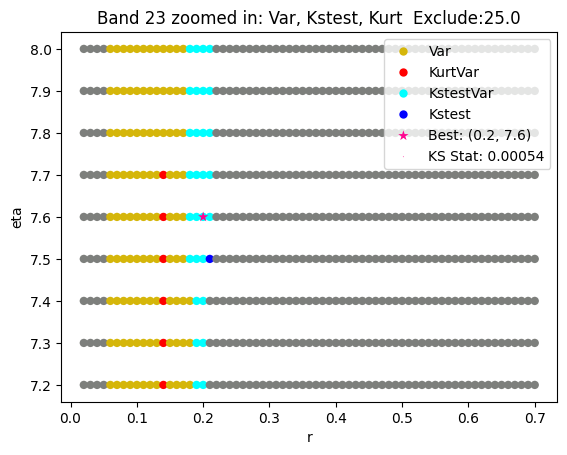

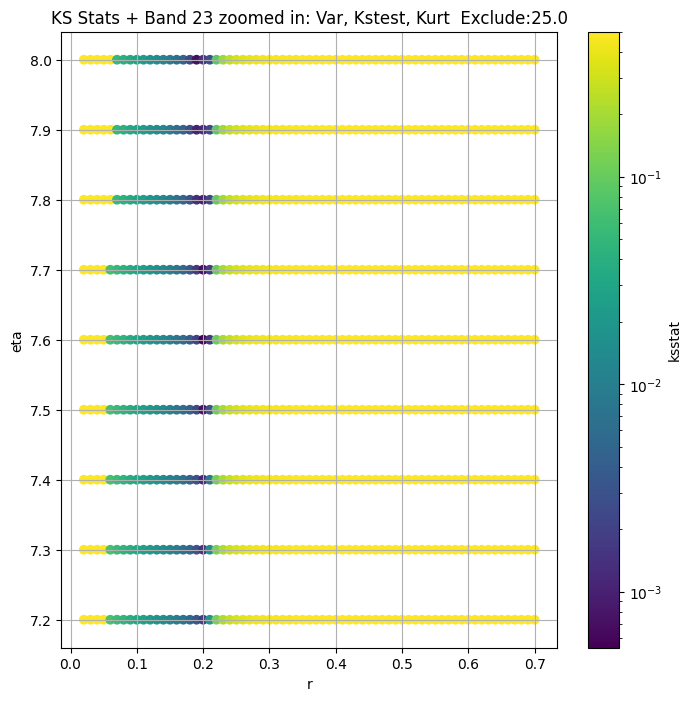

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.0034087522377850357, var: 3022638544015.186


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.002884111294274752, var: 3061199657828.3804


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.002328502002163932, var: 3105251914001.2065


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.0016625099363780094, var: 3158793998806.417


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.0006343875701389778, var: 3254714997040.671
Number of samples: 100000, Without approximation : 100000.0


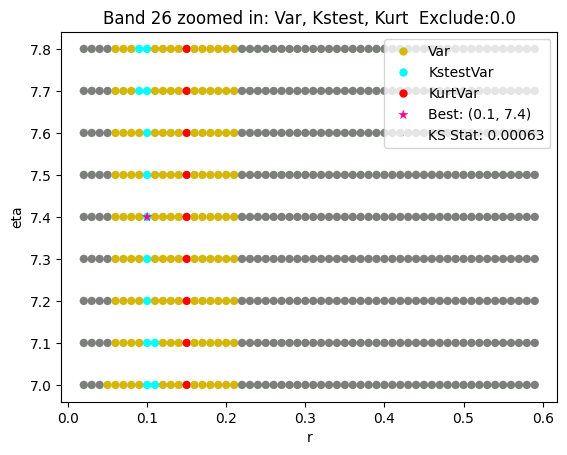

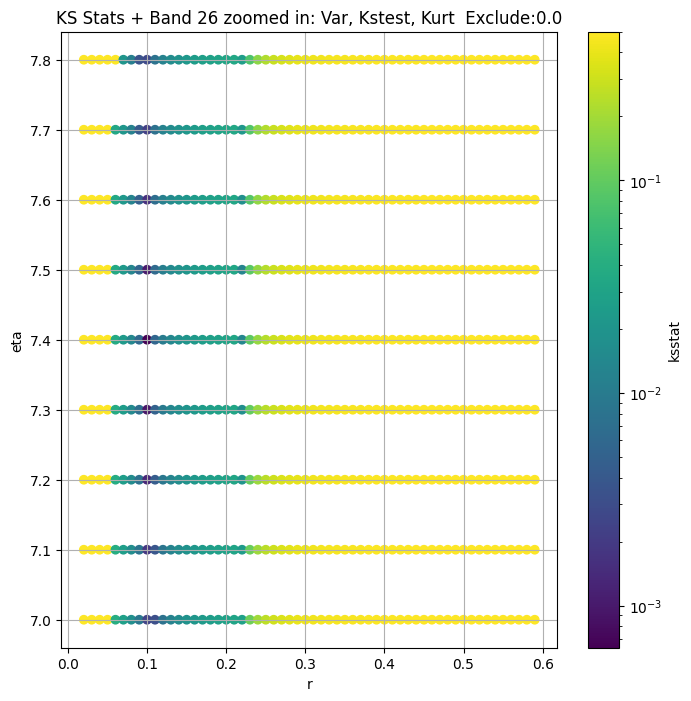

Band 30


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 100 = 100, ksstat: 0.004366720225650843, var: 41293535784.90712


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 75 = 75, ksstat: 0.0040586233597792384, var: 41942822849.6145


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 50 = 50, ksstat: 0.0033236852422192723, var: 42680576420.615654


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 25 = 25, ksstat: 0.002665947968707484, var: 43570540517.67537


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 0 = 0, ksstat: 0.0021487152457839165, var: 45080710644.99423
Number of samples: 100000, Without approximation : 100000.0


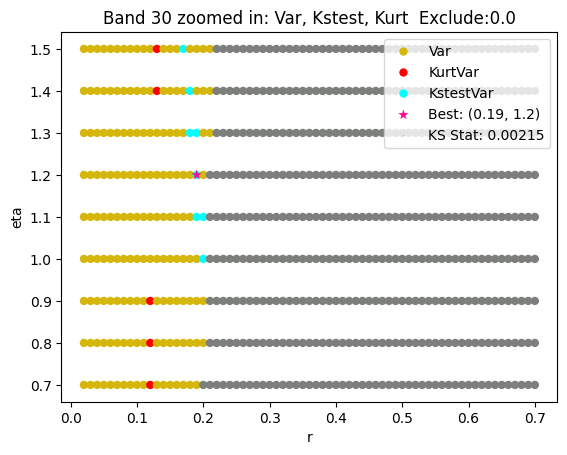

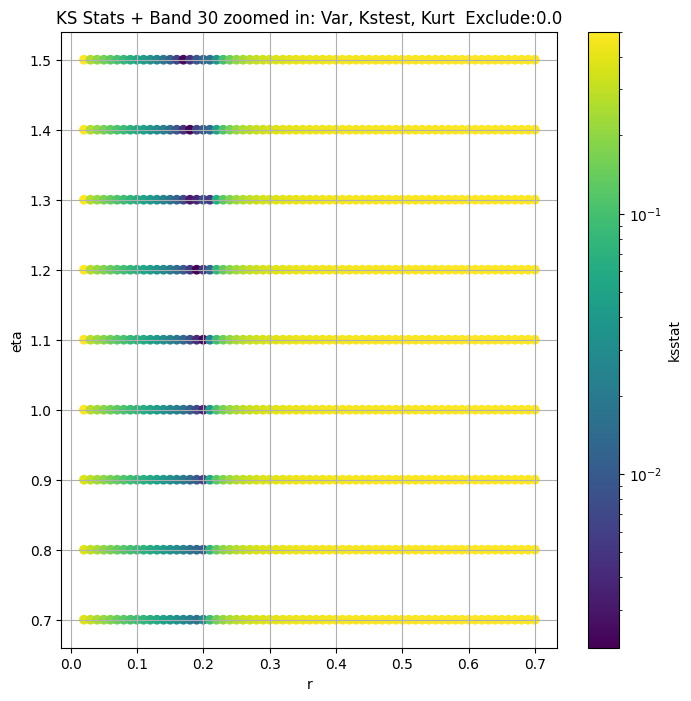

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     2.687462e+14  2.444812e+14  2.967340e+14    6.709019    2.892513   
5     5.361263e+14  4.498260e+14  6.320004e+14   41.450941   33.774703   
8     8.102473e+13  6.454183e+13  1.024136e+14   79.652079   32.607359   
11    1.102342e+13  8.473030e+12  1.559962e+13  159.646159   14.550794   
14    2.499556e+14  2.258030e+14  2.760694e+14   13.192875   10.236113   
17    3.874547e+14  3.631300e+14  4.138468e+14    4.386029    2.848984   
20    8.277627e+13  7.680817e+13  8.937703e+13    6.703176    4.336493   
23    7.691854e+12  7.271829e+12  8.154133e+12    2.935631    1.709797   
26    3.254715e+12  3.037563e+12  3.506743e+12    5.652777    3.258412   
30    4.508071e+10  4.157892e+10  4.895770e+10    7.918080    5.261427   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      10.921011         3072.0             0.006308        0.1         12.0   
5      49.184785         9216.0             0.009561        0.1          6.2   
8     121.646730        26112.0             0.005503        0.2          8.9   
11    415.473312        72192.0             0.003035        0.2         16.0   
14     17.540052       100000.0             0.028279        0.1          0.1   
17      8.834303       100000.0             0.005055        0.1          7.1   
20     12.764984       100000.0             0.001889        0.1          6.9   
23      6.843272       100000.0             0.000536        0.2          7.6   
26     15.071962       100000.0             0.000634        0.1          7.4   
30     16.343210       100000.0             0.002426        0.2          1.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      9.649863e-08                     0.0        2.687462e+14   
5      1.829462e-05                   100.0        2.131422e+14   
8      1.000000e+05                     0.0        8.102473e+13   
11     1.251077e+03                   200.0        7.266264e+12   
14     2.021876e+01                    25.0        2.398283e+14   
17     1.056633e-05                     0.0        3.874547e+14   
20     2.678249e-06                    50.0        7.852253e+13   
23     3.117321e+04                    25.0        7.521187e+12   
26     6.403948e-08                     0.0        3.254715e+12   
30     6.070986e+04                     0.0        4.508071e+10   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.024448          0.006308    0.10      12.0   
5                    0.014129          0.009273    0.11       6.5   
8                    0.008398          0.005503    0.20       8.9   
11                   0.005052          0.002862    0.18      16.0   
14                   0.004293          0.027118    0.12      -0.2   
17                   0.004293          0.005055    0.10       7.1   
20                   0.004293          0.001889    0.10       6.9   
23                   0.004293          0.000536    0.20       7.6   
26                   0.004293          0.000634    0.10       7.4   
30                   0.004293          0.002149    0.19       1.2   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     9.649863e-08                  0.0        44286  
5     1.558494e-03                125.0        20736  
8     1.000000e+05                  0.0        58752  
11    5.788918e+01                175.0       231274  
14    5.651256e+04                 25.0         2635  
17    1.056633e-05                  0.0        75000  
20    2.678249e-06                 50.0       506250  
23    3.117321e+04              

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

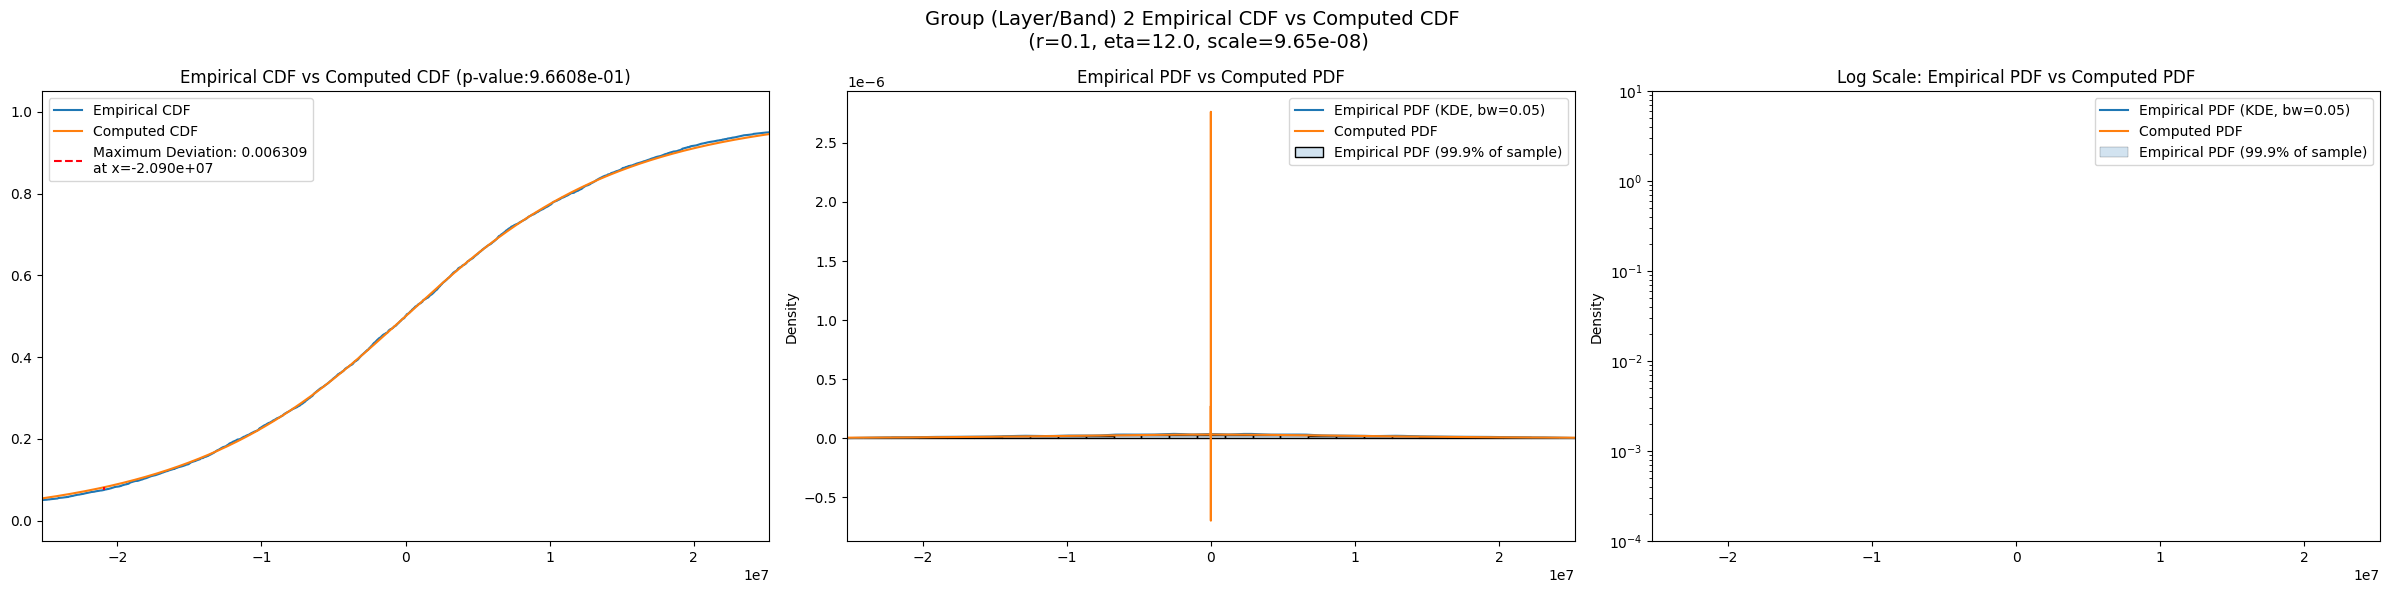

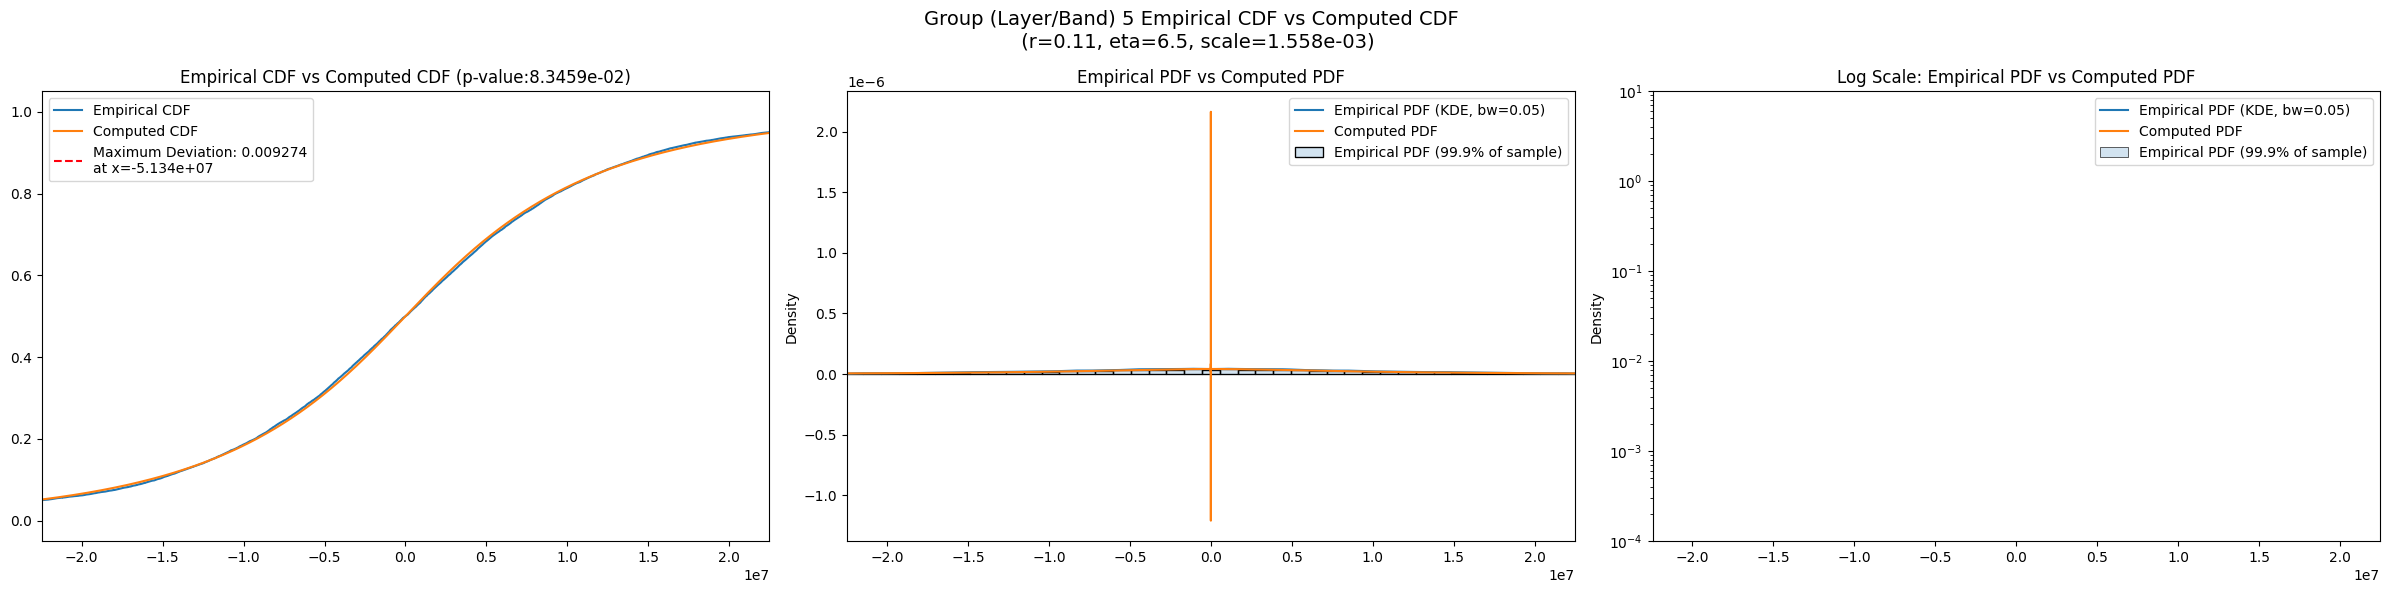

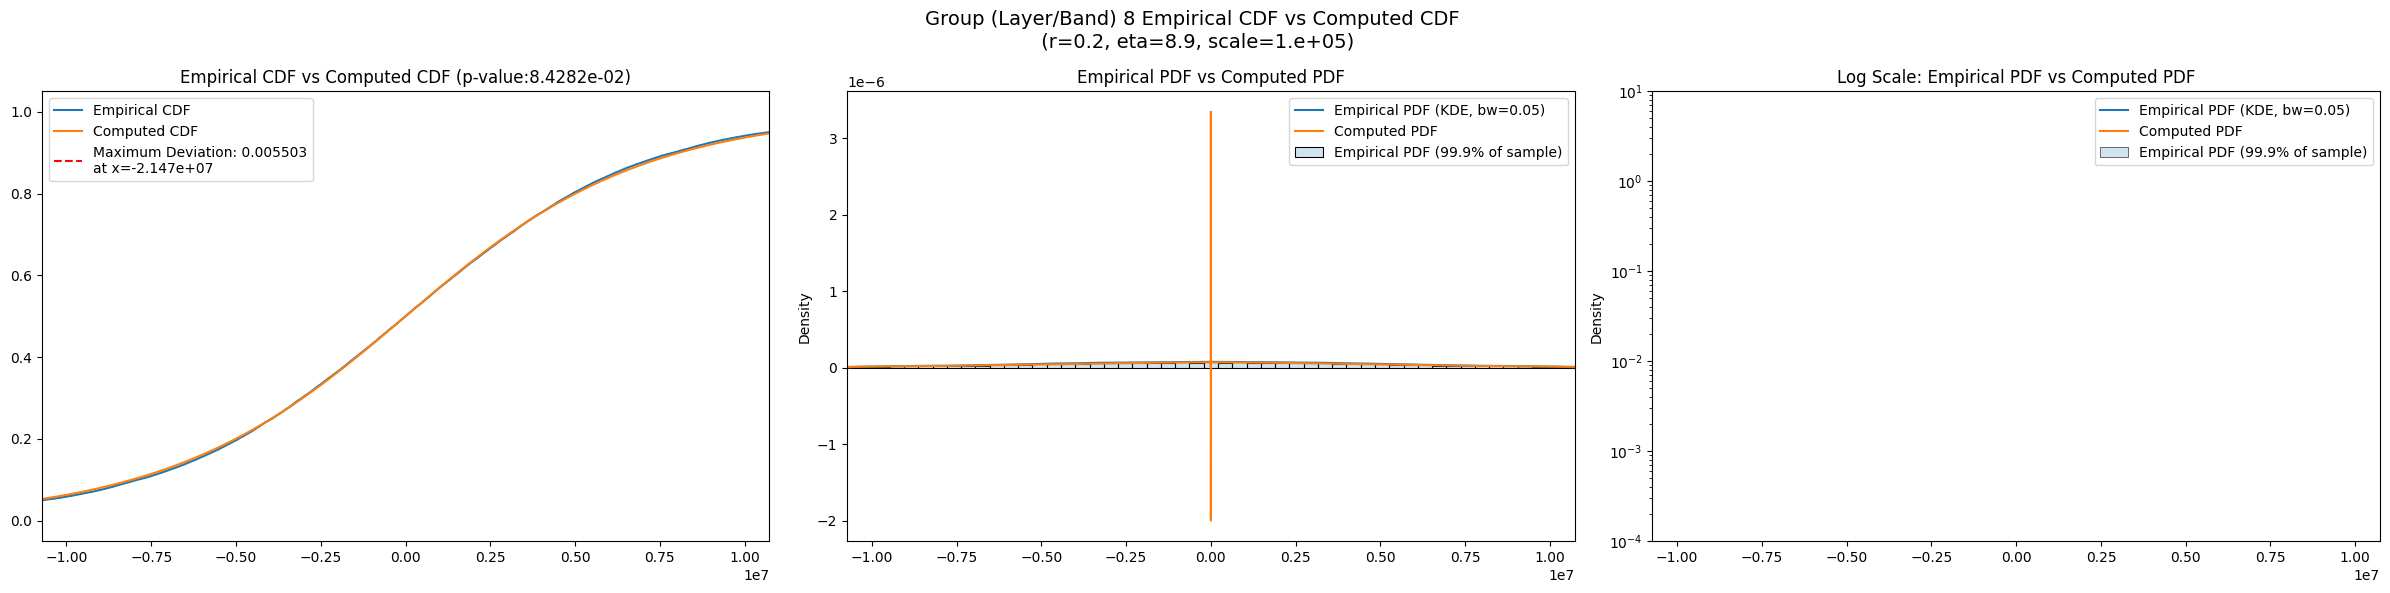

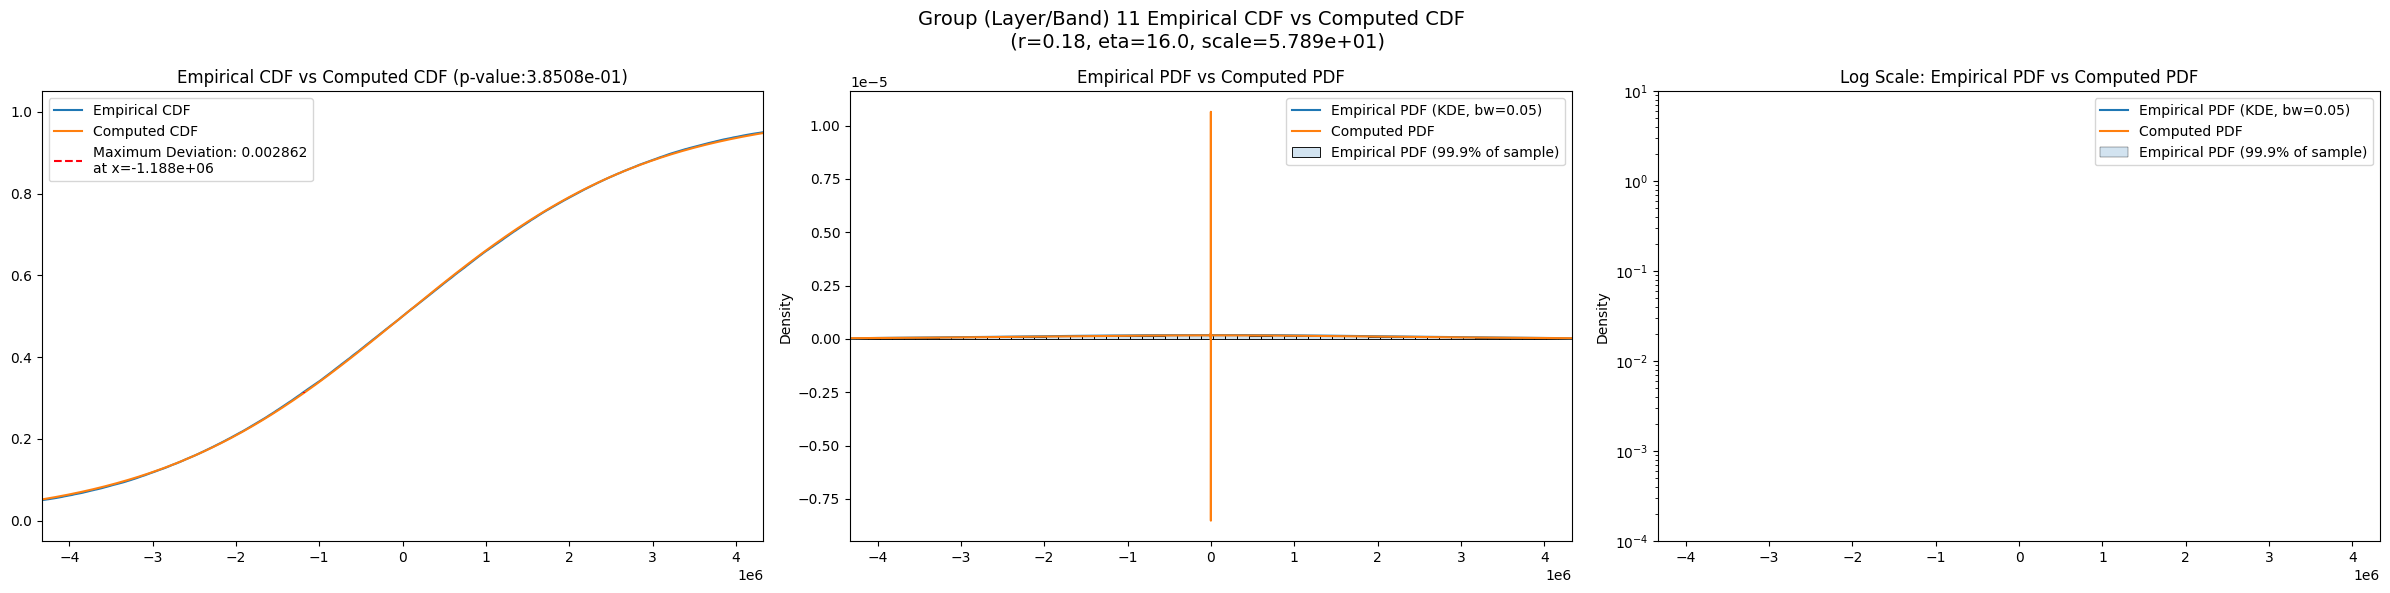

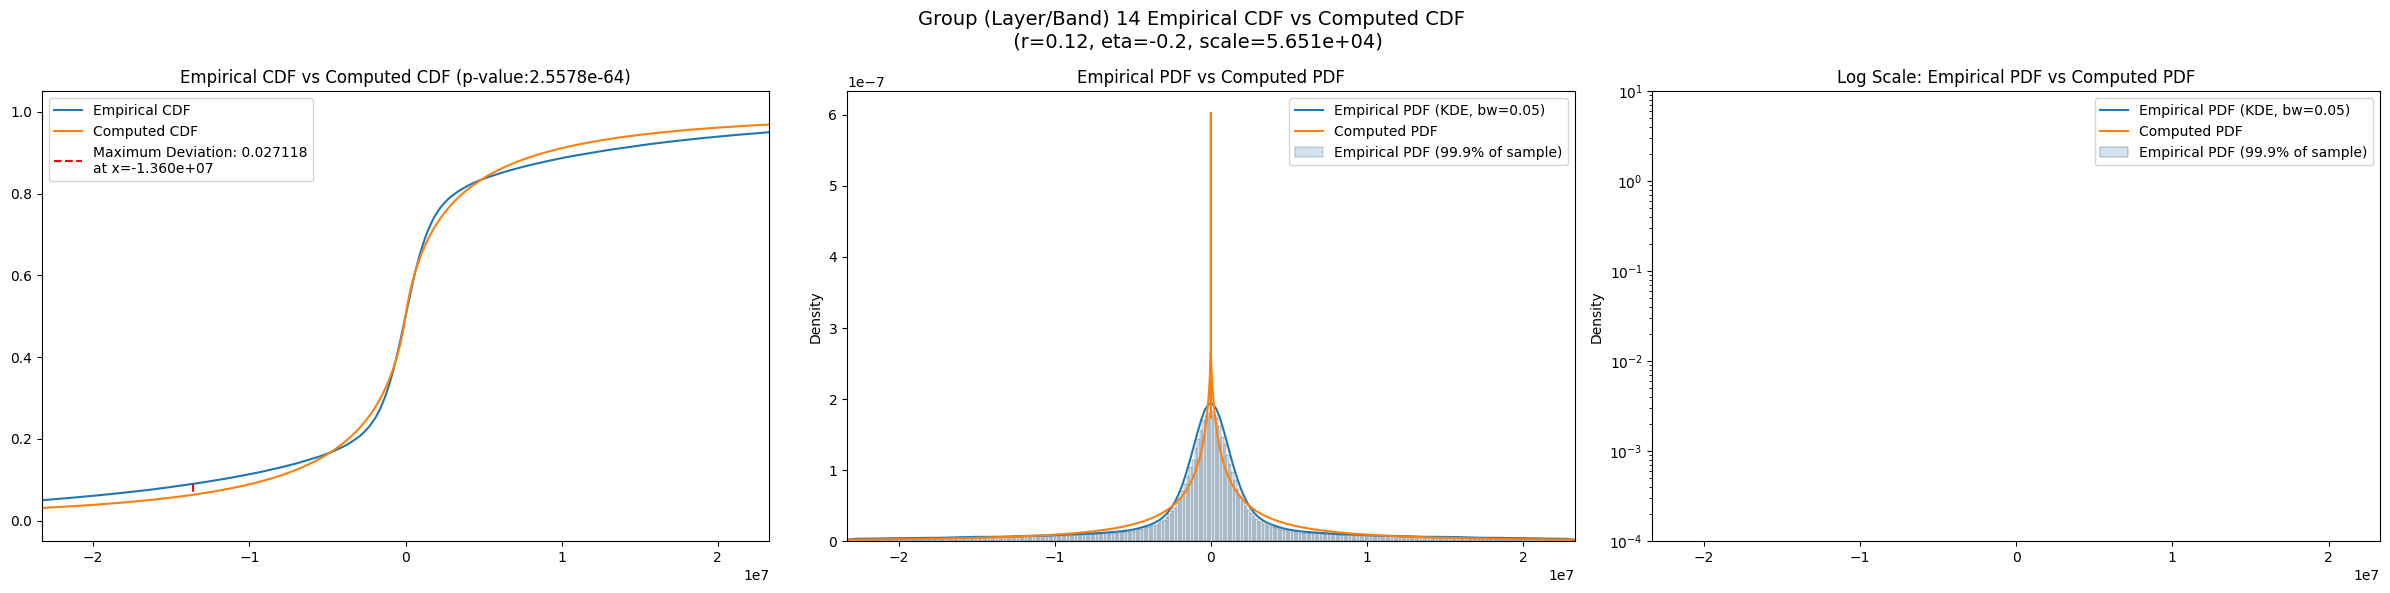

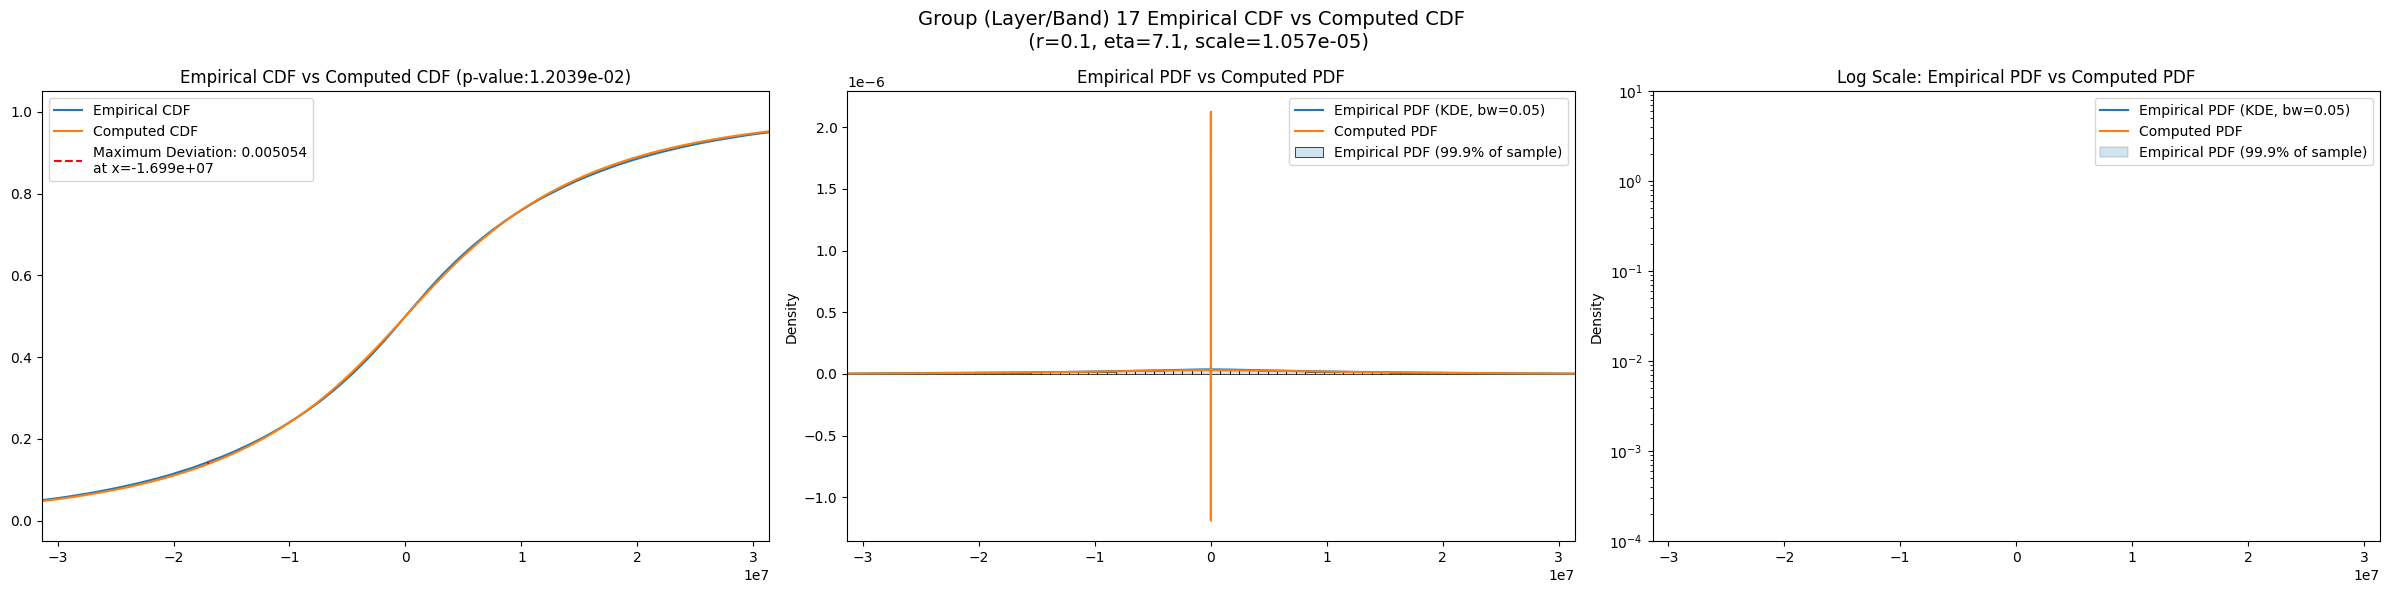

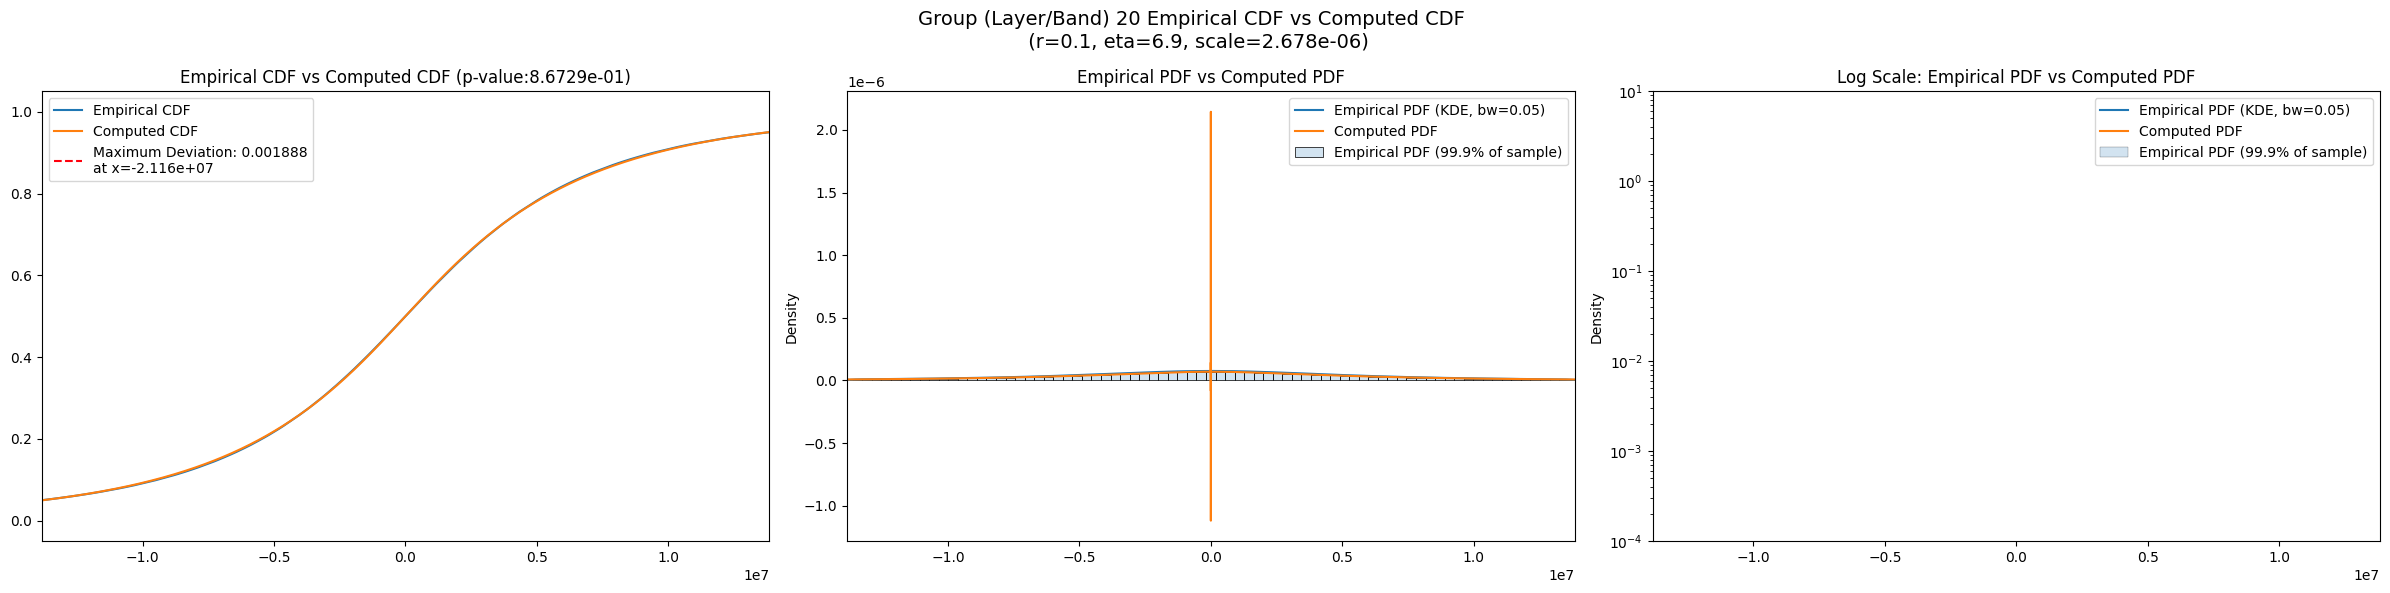

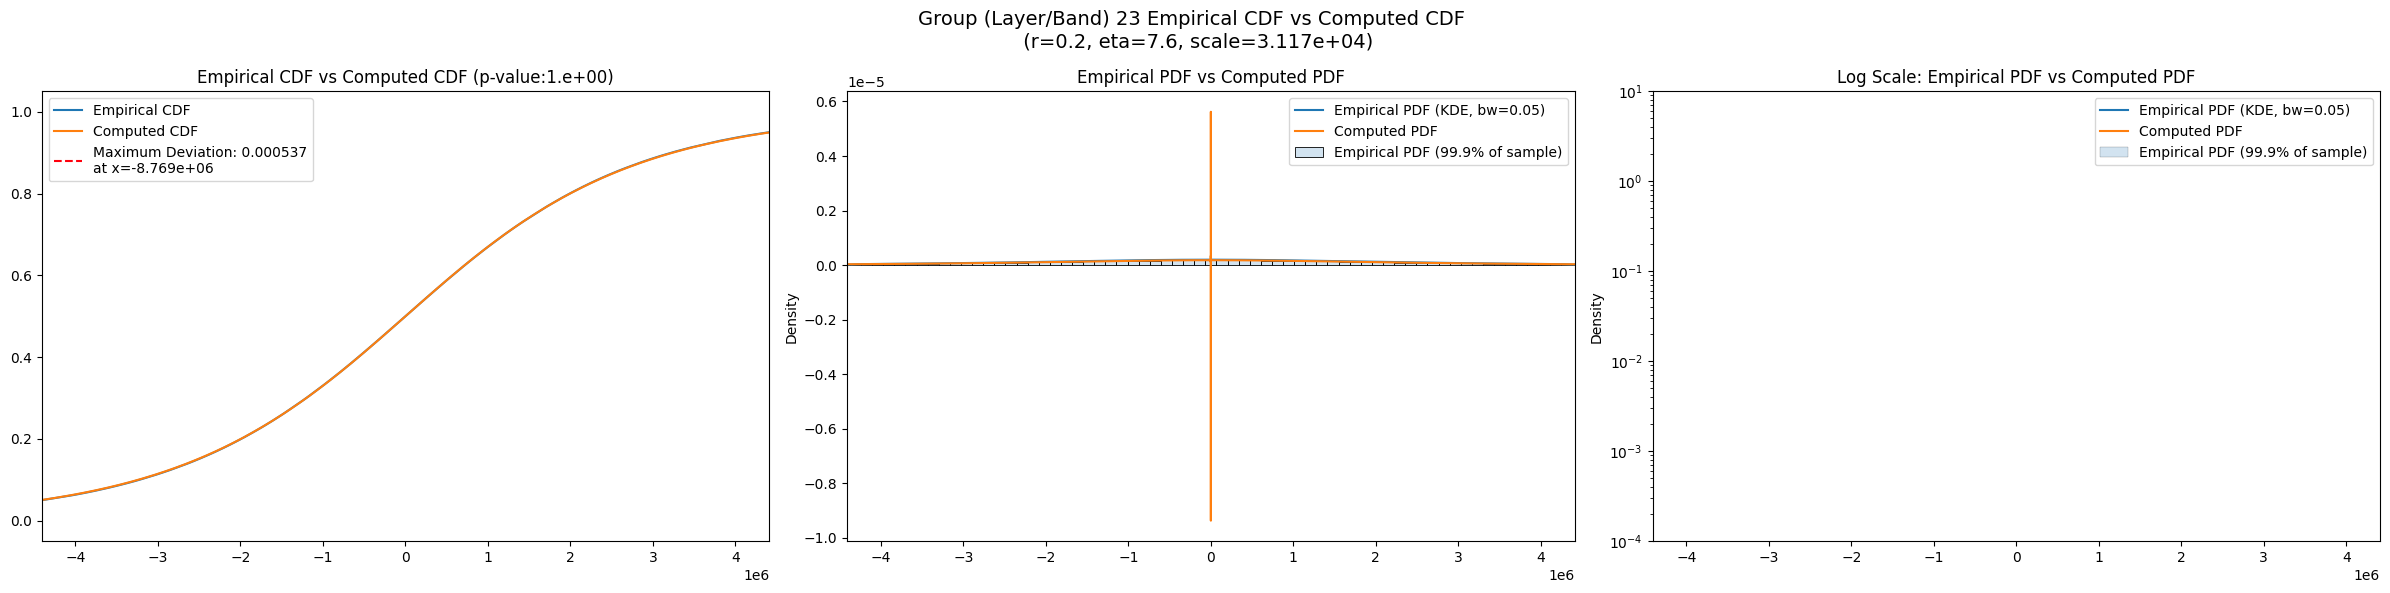

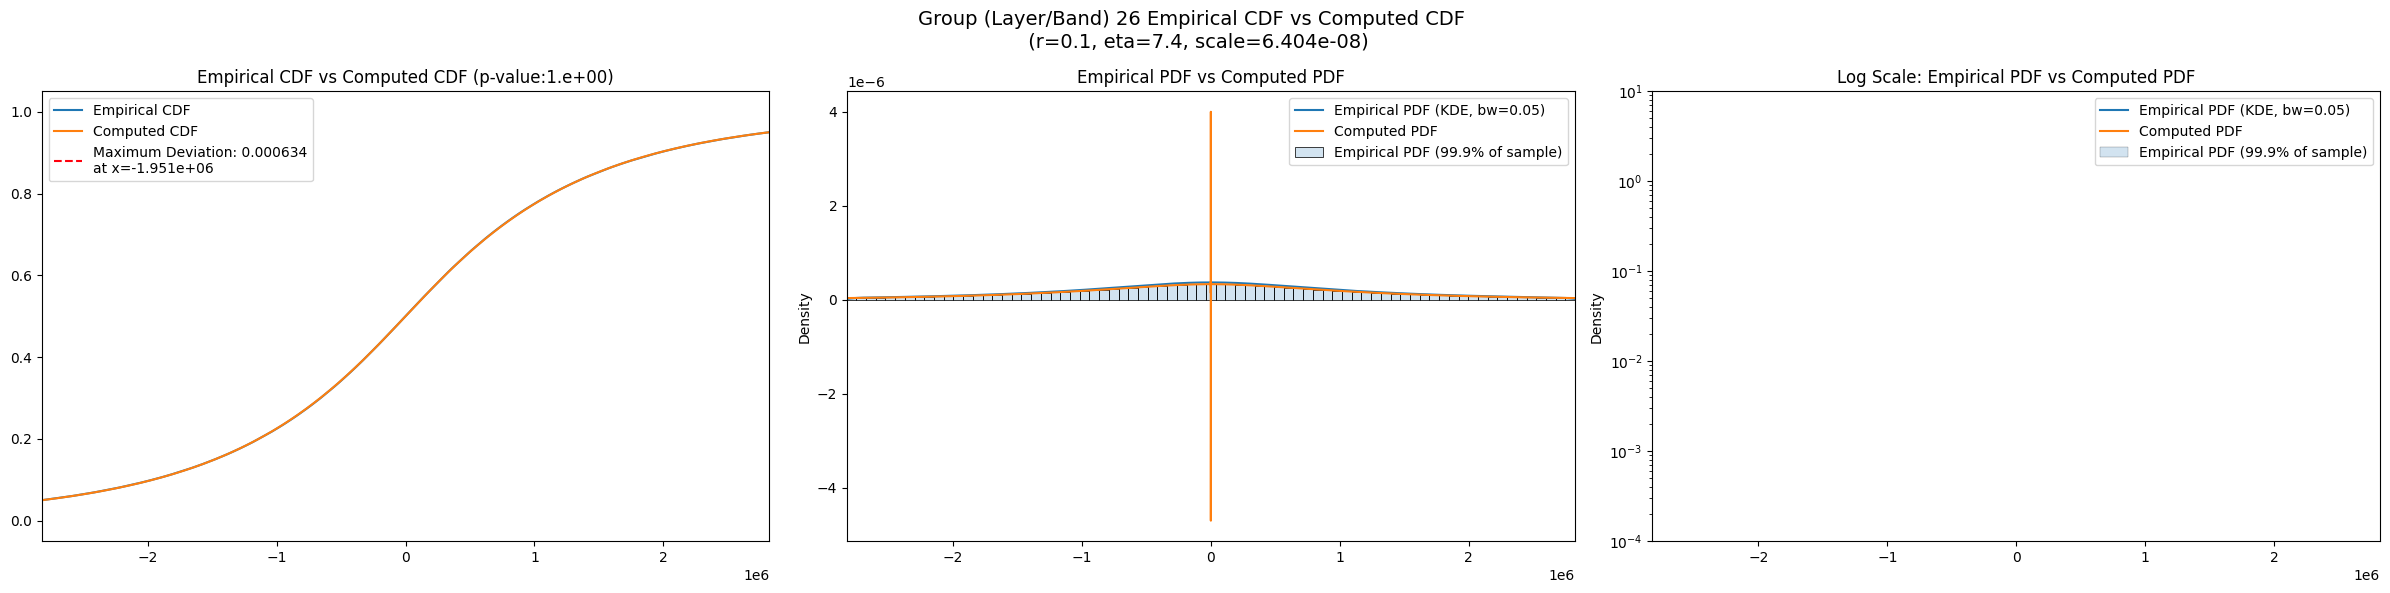

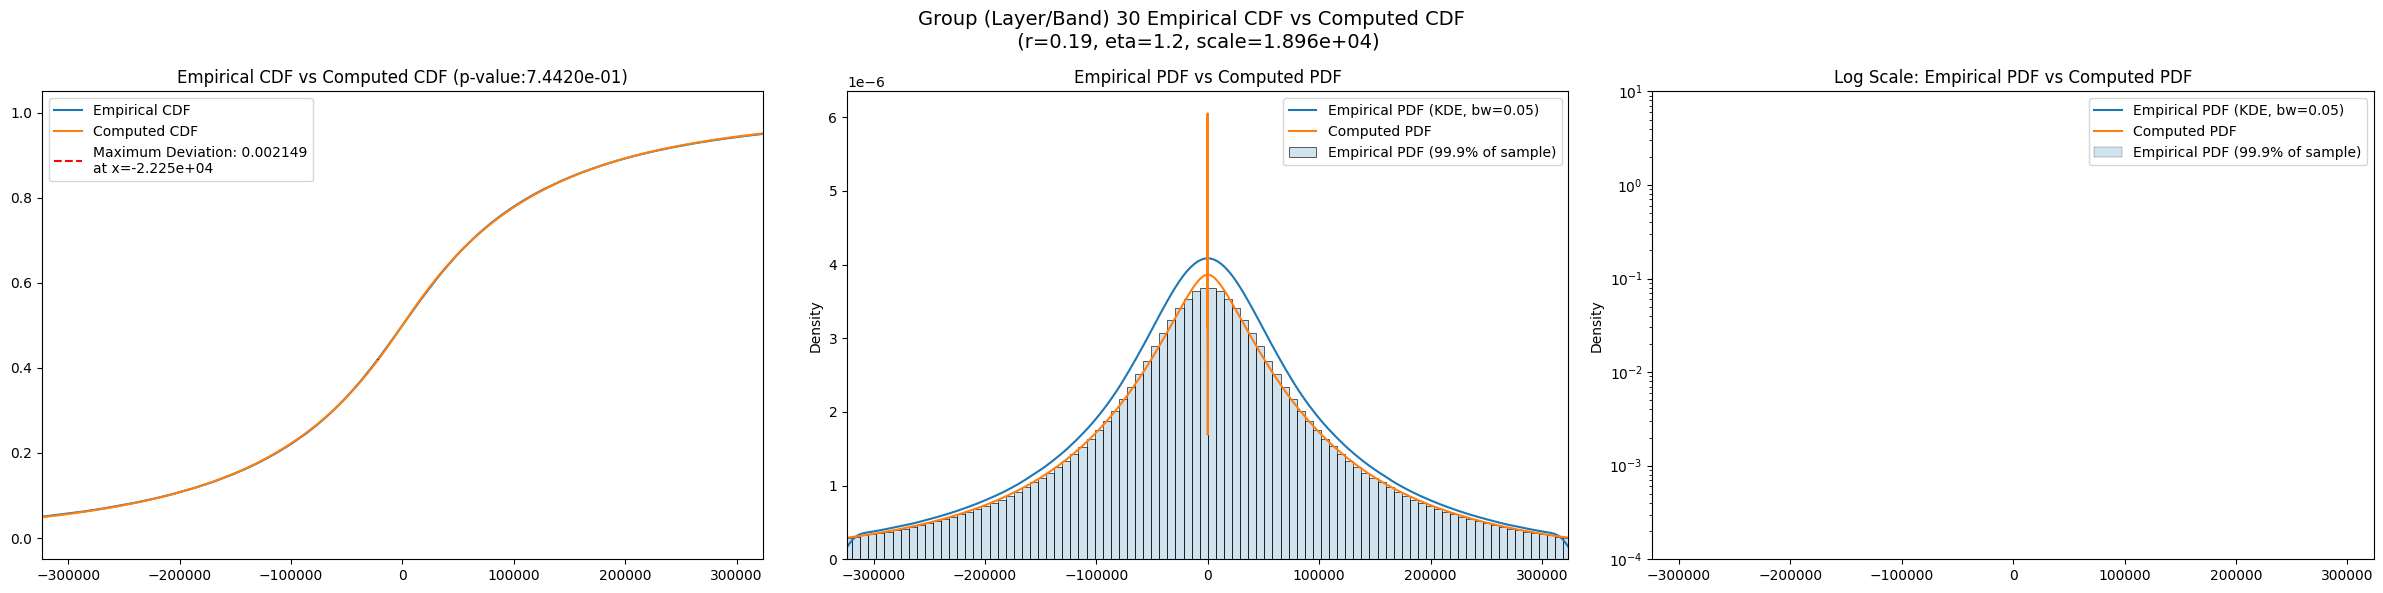

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     2.687462e+14  2.444812e+14  2.967340e+14    6.709019    2.892513   
5     5.361263e+14  4.498260e+14  6.320004e+14   41.450941   33.774703   
8     8.102473e+13  6.454183e+13  1.024136e+14   79.652079   32.607359   
11    1.102342e+13  8.473030e+12  1.559962e+13  159.646159   14.550794   
14    2.499556e+14  2.258030e+14  2.760694e+14   13.192875   10.236113   
17    3.874547e+14  3.631300e+14  4.138468e+14    4.386029    2.848984   
20    8.277627e+13  7.680817e+13  8.937703e+13    6.703176    4.336493   
23    7.691854e+12  7.271829e+12  8.154133e+12    2.935631    1.709797   
26    3.254715e+12  3.037563e+12  3.506743e+12    5.652777    3.258412   
30    4.508071e+10  4.157892e+10  4.895770e+10    7.918080    5.261427   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      10.921011         3072.0             0.006308        0.1         12.0   
5      49.184785         9216.0             0.009561        0.1          6.2   
8     121.646730        26112.0             0.005503        0.2          8.9   
11    415.473312        72192.0             0.003035        0.2         16.0   
14     17.540052       100000.0             0.028279        0.1          0.1   
17      8.834303       100000.0             0.005055        0.1          7.1   
20     12.764984       100000.0             0.001889        0.1          6.9   
23      6.843272       100000.0             0.000536        0.2          7.6   
26     15.071962       100000.0             0.000634        0.1          7.4   
30     16.343210       100000.0             0.002426        0.2          1.1   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       1000000.0              0.420605          0.000000e+00   
5     ...       1000000.0              0.403387          0.000000e+00   
8     ...       1000000.0              0.342685          0.000000e+00   
11    ...       1000000.0              0.204506          0.000000e+00   
14    ...       1000000.0              0.225314          0.000000e+00   
17    ...       1000000.0              0.414631          0.000000e+00   
20    ...       1000000.0              0.345773          0.000000e+00   
23    ...       1000000.0              0.192243          0.000000e+00   
26    ...       1000000.0              0.080924          0.000000e+00   
30    ...        147542.0              0.036927         6.500680e-119   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         1000000.0             0.382393         0.000000e+00  1000000.0   
5         1000000.0             0.365618         0.000000e+00  1000000.0   
8         1000000.0             0.297973         0.000000e+00  1000000.0   
11        1000000.0             0.162361         0.000000e+00  1000000.0   
14        1000000.0             0.182000         0.000000e+00  1000000.0   
17        1000000.0             0.379468         0.000000e+00  1000000.0   
20        1000000.0             0.301114         0.000000e+00  1000000.0   
23        1000000.0             0.150059         0.000000e+00  1000000.0   
26        1000000.0             0.041989        1.227000e-153  1000000.0   
30         129349.0             0.010352         9.761430e-10   105378.0   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.359033   0.000000e+00          9.996520e-01  
5          0.341983   0.000000e+00          4.038933e-01  
8          0.273928   0.000000e+00          4.063396e-01  
11         0.136854   0.000000e+00          5.942922e-01  
14         0.1581

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.006308                 0.024448          0.006308   
5                0.009561                 0.014129          0.009273   
8                0.005503                 0.008398          0.005503   
11               0.003035                 0.005052          0.002862   
14               0.028279                 0.004293          0.027118   
17               0.005055                 0.004293          0.005055   
20               0.001889                 0.004293          0.001889   
23               0.000536                 0.004293          0.000536   
26               0.000634                 0.004293          0.000634   
30               0.002426                 0.004293          0.002149   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.420605             0.382393       0.359033  
5                 0.403387             0.365618       0.341983  
8                 0.342685             0.297973       0.273928  
11                0.204506             0.162361       0.136854  
14                0.225314             0.182000       0.158192  
17                0.414631             0.379468       0.356276  
20                0.345773             0.301114       0.277075  
23                0.192243             0.150059       0.124563  
26                0.080924             0.041989       0.013824  
30                0.036927             0.010352       0.008994

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2           2.687462e+14          0.006308    0.10      12.0  9.649863e-08   
5           2.131422e+14          0.009273    0.11       6.5  1.558494e-03   
8           8.102473e+13          0.005503    0.20       8.9  1.000000e+05   
11          7.266264e+12          0.002862    0.18      16.0  5.788918e+01   
14          2.398283e+14          0.027118    0.12      -0.2  5.651256e+04   
17          3.874547e+14          0.005055    0.10       7.1  1.056633e-05   
20          7.852253e+13          0.001889    0.10       6.9  2.678249e-06   
23          7.521187e+12          0.000536    0.20       7.6  3.117321e+04   
26          3.254715e+12          0.000634    0.10       7.4  6.403948e-08   
30          4.508071e+10          0.002149    0.19       1.2  1.895613e+04   

      best_exclude_cutoff  
band                       
2                     0.0  
5                   125.0  
8                     0.0  
11                  175.0  
14                   25.0  
17                    0.0  
20                   50.0  
23                   25.0  
26                    0.0  
30                    0.0